# 💼 고객 통화 패턴 및 서비스 접점 데이터를 활용한 이탈 선행 지표 발굴 및 방어 전략   
### 사용량 감소보다 강력한 '불만 시그널' 포착을 중심으로

## 1. 문제 정의 및 데이터 이해

### **기본 정보**
--- 
**데이터**: Telecom Churn Dataset   

**비지니스 문제**: 기존 고객의 유지(Retention) 비용이 신규 유치 비용보다 훨씬 낮음에도 불구하고, 핵심 고객층의 이탈 징후를 사전에 포착하지 못해 매출 손실이 발생하고 있다.    

**분석 목표**
- **선행 지표 발굴** : 통화량 및 요금과 고객센터 호출 횟수 중 더 결정적 요인을 통계적으로 규명한다.
- **Tipping Point 식별** : 포아송 분포 분석을 통해 단순 불편을 넘어선 폭발적 불만이 발생하는 수학적 분기점을 찾아내고 이탈률의 비선형적 급증 구간을 찾는다.
- **방어 전략 수립** : 고객을 세분화하여 실무에서 활용 가능한 데이터 기반 조기 경보 시스템을 만든다.

---

### **데이터셋 구조 파악**

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

df = pd.read_csv('churn-bigml-80_KS.csv')

target_col = 'Churn' 

# 데이터 분리
train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df[target_col] 
)

# 클래스 분포
class_ratio = train_df[target_col].value_counts(normalize=True)

churn_percentage = class_ratio[True] * 100

print(f"Dataset Shape: {train_df.shape}")
print(f"소수 클래스(이탈) 비중: {churn_percentage}%")

# 4. 샘플 확인
print(f"\nSample Data:")
display(train_df.head(10))


Dataset Shape: (2132, 20)
소수 클래스(이탈) 비중: 14.540337711069418%

Sample Data:


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
1229,MD,102,415,No,No,0,271.1,80,46.09,172.0,133,14.62,169.2,105,7.61,10.3,5,2.78,1,False
2001,MT,157,408,No,No,0,240.2,67,40.83,153.0,98,13.01,249.0,72,11.21,10.2,6,2.75,2,False
1421,TX,79,415,No,No,0,144.0,90,24.48,135.8,91,11.54,212.4,129,9.56,13.0,4,3.51,1,False
1346,NM,132,408,No,No,0,169.9,107,28.88,209.4,121,17.80,206.1,79,9.27,11.5,2,3.11,1,False
86,AZ,95,408,No,No,0,238.1,65,40.48,187.2,98,15.91,190.0,115,8.55,11.8,4,3.19,4,False
421,MO,61,408,No,No,0,45.0,108,7.65,151.3,74,12.86,152.9,94,6.88,9.8,6,2.65,2,False
1549,NC,124,415,No,No,0,188.5,77,32.05,182.0,123,15.47,218.2,127,9.82,6.1,6,1.65,1,False
590,AL,146,415,No,Yes,32,154.0,80,26.18,185.5,91,15.77,148.2,107,6.67,8.2,4,2.21,3,False
1477,MA,69,510,No,No,0,195.1,91,33.17,261.5,57,22.23,203.8,90,9.17,11.4,5,3.08,0,False
898,LA,9,415,No,Yes,39,214.1,108,36.40,169.2,115,14.38,189.7,117,8.54,10.1,3,2.73,1,False


In [37]:
# 이탈 비율 확인
print(df[target_col].value_counts(normalize=True))

print(f"훈련 데이터 크기: {train_df.shape}")
print(f"검증 데이터 크기: {val_df.shape}")

Churn
False    0.854464
True     0.145536
Name: proportion, dtype: float64
훈련 데이터 크기: (2132, 20)
검증 데이터 크기: (534, 20)


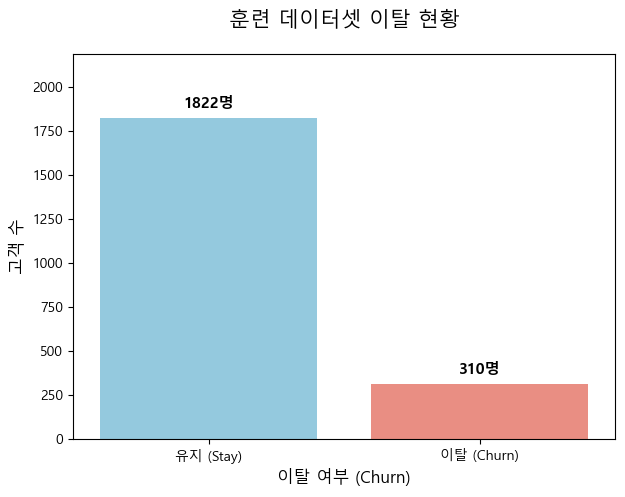

In [38]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

vc = train_df[target_col].value_counts()

plt.figure(figsize=(7, 5))

ax = sns.barplot(x=vc.index, y=vc.values, hue=vc.index, palette=['skyblue', 'salmon'], legend=False)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}명', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=11, fontweight='bold')

plt.title("훈련 데이터셋 이탈 현황", fontsize=15, pad=20)
plt.xlabel("이탈 여부 (Churn)", fontsize=12)
plt.ylabel("고객 수", fontsize=12)

plt.xticks(ticks=[0, 1], labels=['유지 (Stay)', '이탈 (Churn)'])
plt.ylim(0, vc.max() * 1.2) 

plt.show()

## 2. 데이터 전처리

### **결측치 처리**

In [39]:
print(train_df.isnull().sum())

print(val_df.isnull().sum())

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64
State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total i

### **이상치 탐지 및 처리**

In [40]:
# Capping 기법 사용
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 상하한선을 벗어나는 값을 각 경계값으로 대체
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    return df

# 이상치가 163개로 많이 나온 'Customer service calls' 컬럼이 불필요해진다면 실행하여 이상치 처리하기
# 실행하면 데이터의 분산이 줄어들어 학습하기에 부드러워지지만, 고객 특성이 평범해질 수 있다.
# train_df = handle_outliers(train_df, 'Customer service calls')
# val_df = handle_outliers(val_df, 'Customer service calls')

### **데이터 타입 변환**

In [41]:
# objct -> int 타입으로 바꾸기
from sklearn.preprocessing import LabelEncoder

binary_cols = ['International plan', 'Voice mail plan']
for col in binary_cols:
    train_df[col] = train_df[col].map({'Yes': 1, 'No': 0})
    val_df[col] = val_df[col].map({'Yes': 1, 'No': 0})

le = LabelEncoder()
train_df['State'] = le.fit_transform(train_df['State'])
val_df['State'] = le.transform(val_df['State']) # 검증셋은 fit 없이 transform만 진행

train_df['Churn'] = train_df['Churn'].astype(int)
val_df['Churn'] = val_df['Churn'].astype(int)

print(train_df[['State', 'International plan', 'Voice mail plan', 'Churn']].info())

<class 'pandas.DataFrame'>
Index: 2132 entries, 1229 to 1640
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   State               2132 non-null   int64
 1   International plan  2132 non-null   int64
 2   Voice mail plan     2132 non-null   int64
 3   Churn               2132 non-null   int64
dtypes: int64(4)
memory usage: 83.3 KB
None


In [42]:
# Z-Score로 표준화

from sklearn.preprocessing import StandardScaler

# 스케일링할 수치형 컬럼 리스트 (타겟 변수 제외)
num_cols = [
    'Account length', 'Number vmail messages', 'Total day minutes', 
    'Total day calls', 'Total day charge', 'Total eve minutes', 
    'Total eve calls', 'Total eve charge', 'Total night minutes', 
    'Total night calls', 'Total night charge', 'Total intl minutes', 
    'Total intl calls', 'Total intl charge', 'Customer service calls'
]

scaler = StandardScaler()

# 훈련 데이터로 기준(평균, 표준편차)을 정하고 변환
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])

# 검증 데이터는 훈련 데이터의 기준을 그대로 적용
val_df[num_cols] = scaler.transform(val_df[num_cols])

print("\n--- 스케일링 완료 후 데이터 샘플 ---")
print(train_df[num_cols].head())



--- 스케일링 완료 후 데이터 샘플 ---
      Account length  Number vmail messages  Total day minutes  \
1229        0.033303              -0.583143           1.688380   
2001        1.423013              -0.583143           1.118432   
1421       -0.547849              -0.583143          -0.655970   
1346        0.791327              -0.583143          -0.178246   
86         -0.143569              -0.583143           1.079698   

      Total day calls  Total day charge  Total eve minutes  Total eve calls  \
1229        -1.009029          1.688657          -0.562170         1.639851   
2001        -1.655453          1.117947          -0.932862        -0.111558   
1421        -0.511780         -0.656028          -1.268436        -0.461840   
1346         0.333544         -0.178628           0.167508         1.039368   
86          -1.754903          1.079972          -0.265617        -0.111558   

      Total eve charge  Total night minutes  Total night calls  \
1229         -0.562232            -0

## 3. EDA

### **단변량 분석 (Univariate Analysis)**
- 수치형 변수: 히스토그램, 박스플롯으로 분포 확인
- 기술통계량 산출 (평균, 중앙값, 표준편차, 사분위수)
- 범주형 변수: 빈도표, 막대그래프로 분포 확인
- 타겟 변수(Churn) 불균형 비율 계산

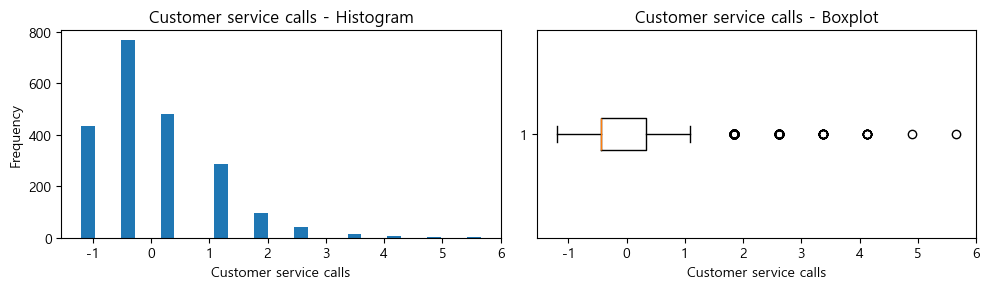

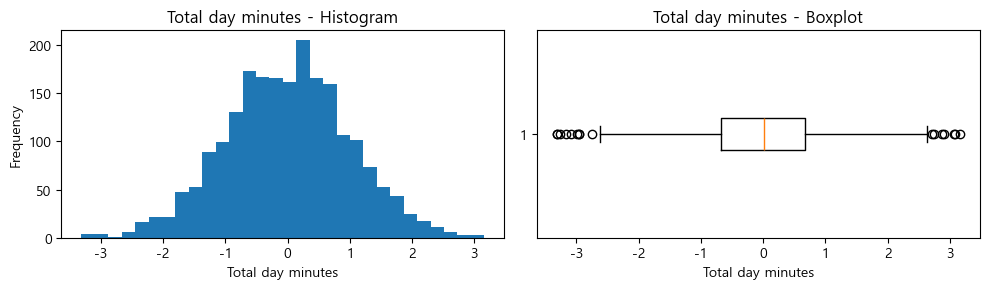

In [43]:
# 수치형 변수
num_targets = ["Customer service calls", "Total day minutes"]

for col in num_targets:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    
    train_df[col].plot(kind="hist", bins=30, ax=axes[0])
    axes[0].set_title(f"{col} - Histogram")
    axes[0].set_xlabel(col)
    
    axes[1].boxplot(train_df[col], vert=False)
    axes[1].set_title(f"{col} - Boxplot")
    axes[1].set_xlabel(col)
    
    plt.tight_layout()
    plt.show()

In [44]:
# 기술통계량 산출
desc = train_df[num_targets].describe().T
desc["median"] = train_df[num_targets].median()
desc = desc[["count","mean","median","std","min","25%","50%","75%","max"]]
desc

,count,mean,median,std,min,25%,50%,75%,max
Customer service calls,2132.0,3.999302e-17,-0.434702,1.000235,-1.196233,-0.434702,-0.434702,0.326830,5.657550
Total day minutes,2132.0,-6.332229e-16,0.006203,1.000235,-3.312039,-0.672570,0.006203,0.664687,3.158441


In [45]:
# 범주형 변수
cat_cols = train_df.select_dtypes(include="object").columns
print(cat_cols)

print("결과가 Index([], dtype='object')면 '범주형 없음'이나 'str'로 나와 범주 없음")

Index([], dtype='str')
결과가 Index([], dtype='object')면 '범주형 없음'이나 'str'로 나와 범주 없음


In [46]:
# 타겟 변수 불균형 비율 계산
churn_counts = train_df["Churn"].value_counts()
churn_ratio = train_df["Churn"].value_counts(normalize=True) * 100

print(churn_counts)
print("\nChurn ratio (%)")
print(churn_ratio.round(2))

Churn
0    1822
1     310
Name: count, dtype: int64

Churn ratio (%)
Churn
0    85.46
1    14.54
Name: proportion, dtype: float64


In [47]:
# 포아송 분포

from math import exp, factorial

x = train_df["Customer service calls"].astype(int)

mu = x.mean()
var = x.var(ddof=0)

print(f"Poisson check for 'Customer service calls'")
print(f"mean (mu) = {mu:.3f}")
print(f"variance  = {var:.3f}")
print(f"variance/mean = {var/mu:.3f}")

# 실제 빈도
max_k = int(x.max())
obs = x.value_counts().sort_index()
obs = obs.reindex(range(0, max_k+1), fill_value=0)

# 포아송 기대 빈도 (mu 기준) : 반응 변수가 '개수'이고 낮은 확률의 무작위인 경우 포아송 사용
n = len(x)
exp_counts = np.array([n * (np.exp(-mu) * (mu**k) / factorial(k)) for k in range(0, max_k+1)])

poisson_compare = (
    pd.DataFrame({"Observed": obs.values, "Expected(Poisson)": exp_counts}, index=range(0, max_k+1))
    .round(2)
)

poisson_compare

Poisson check for 'Customer service calls'
mean (mu) = 0.056
variance  = 0.600
variance/mean = 10.660


,Observed,Expected(Poisson)
0,1248,2015.31
1,385,113.43
2,41,3.19
3,15,0.06
4,9,0.00
5,1,0.00


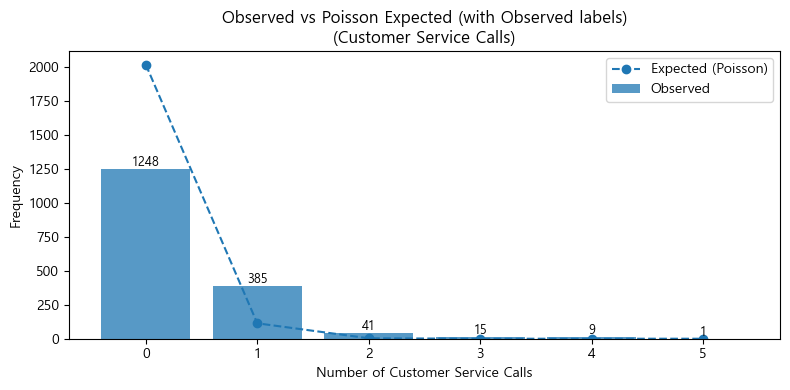

In [48]:
# 시각화
k = poisson_compare.index.to_list()
observed = poisson_compare["Observed"].values
expected = poisson_compare["Expected(Poisson)"].values

plt.figure(figsize=(8, 4))

bars = plt.bar(k, observed, alpha=0.75, label="Observed")

plt.plot(k, expected, marker="o", linestyle="--", label="Expected (Poisson)")

for bar in bars:
    height = bar.get_height()
    if height > 0:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{int(height)}",
            ha="center",
            va="bottom",
            fontsize=9
        )

plt.xlabel("Number of Customer Service Calls")
plt.ylabel("Frequency")
plt.title("Observed vs Poisson Expected (with Observed labels)\n(Customer Service Calls)")
plt.xticks(k)
plt.legend()
plt.tight_layout()
plt.show()

### **이변량 분석 (Bivariate Analysis)**
- 수치형 변수 vs Churn: 박스플롯, 바이올린 플롯으로 그룹 간 차이 확인
- 범주형 변수 vs Churn: 교차표(Crosstab), 스택 바 차트로 이탈률 비교
- 통계적 검정: t-test (연속형), Chi-square test (범주형)로 유의성 확인
- 핵심 인사이트 도출: "고객 서비스 호출이 4회 이상인 고객의 이탈률이 50% 이상" 등


 수치형 변수 vs Churn: 


C:\Users\User\AppData\Local\Temp\ipykernel_3576\3108718464.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_no, data_yes], labels=["Churn=False", "Churn=True"], showfliers=True)


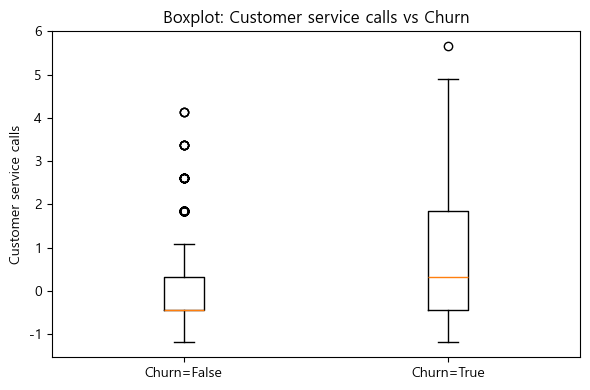

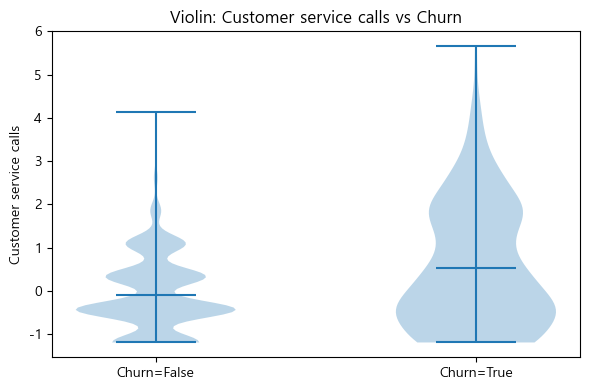

C:\Users\User\AppData\Local\Temp\ipykernel_3576\3108718464.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_no, data_yes], labels=["Churn=False", "Churn=True"], showfliers=True)


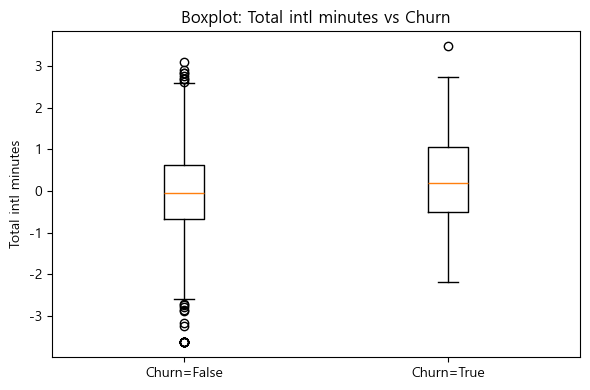

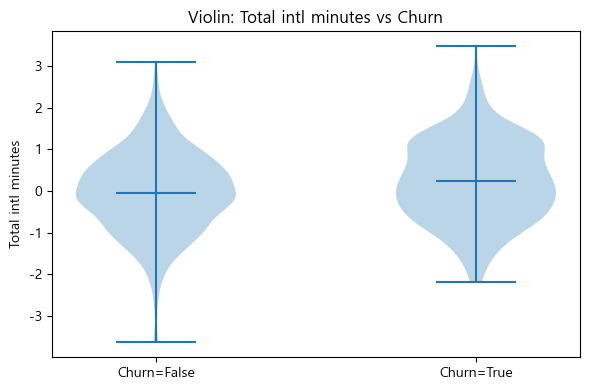

C:\Users\User\AppData\Local\Temp\ipykernel_3576\3108718464.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_no, data_yes], labels=["Churn=False", "Churn=True"], showfliers=True)


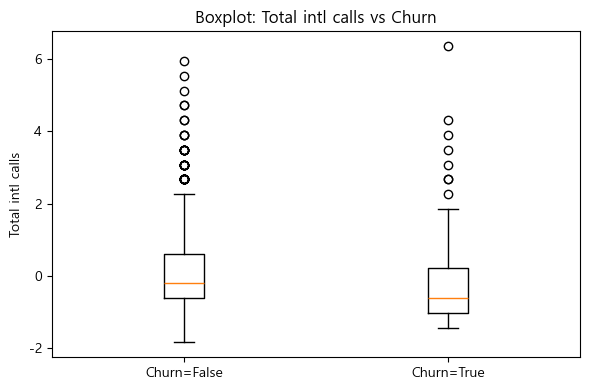

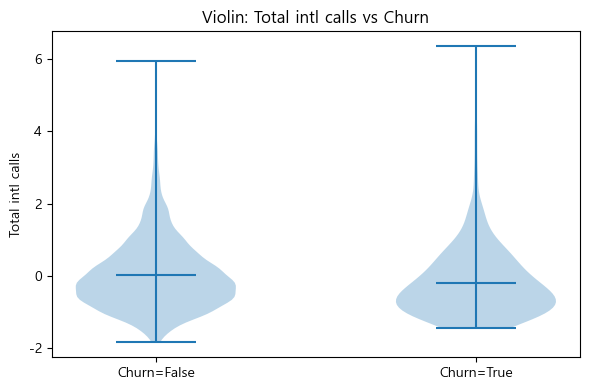

C:\Users\User\AppData\Local\Temp\ipykernel_3576\3108718464.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_no, data_yes], labels=["Churn=False", "Churn=True"], showfliers=True)


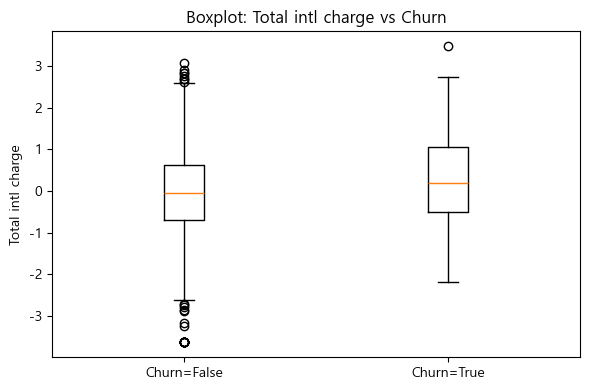

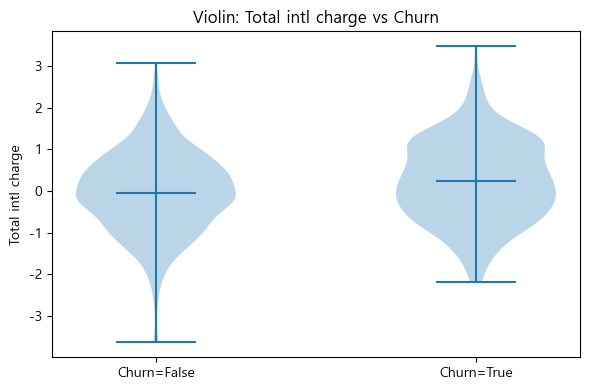

C:\Users\User\AppData\Local\Temp\ipykernel_3576\3108718464.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_no, data_yes], labels=["Churn=False", "Churn=True"], showfliers=True)


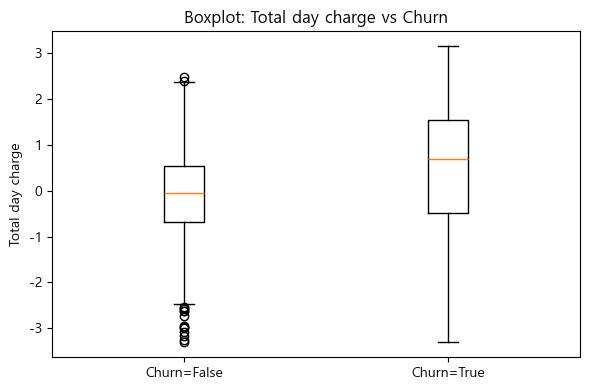

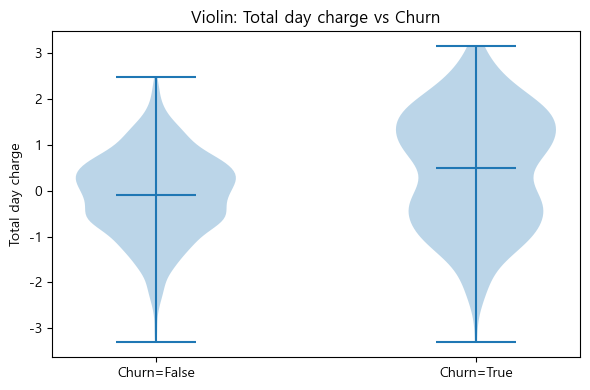

In [49]:
# 수치형 변수 vs Churn
num_features = [
    "Customer service calls",
    "Total intl minutes",
    "Total intl calls",
    "Total intl charge",
    "Total day charge"  # 고액 사용(프록시)
]

def boxplot_by_churn(df, col):
    data_no  = df[df["Churn"] == False][col].dropna()
    data_yes = df[df["Churn"] == True][col].dropna()

    plt.figure(figsize=(6,4))
    plt.boxplot([data_no, data_yes], labels=["Churn=False", "Churn=True"], showfliers=True)
    plt.title(f"Boxplot: {col} vs Churn")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

def violin_by_churn(df, col):
    data_no  = df[df["Churn"] == False][col].dropna().values
    data_yes = df[df["Churn"] == True][col].dropna().values

    plt.figure(figsize=(6,4))
    vp = plt.violinplot([data_no, data_yes], showmeans=True, showextrema=True)
    plt.xticks([1,2], ["Churn=False", "Churn=True"])
    plt.title(f"Violin: {col} vs Churn")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

print("\n 수치형 변수 vs Churn: ")
for col in num_features:
    if col in train_df.columns:
        boxplot_by_churn(train_df, col)
        violin_by_churn(train_df, col)

In [50]:
# 아래 그래프 표시 시 에러가 생겨서 이것을 추가하였습니다. 

import pandas as pd
import matplotlib.pyplot as plt

def crosstab_churn_rate(df, col, target_col="Churn"):
    """
    col별 Churn 분포를
    - 비율표(ct_prop)
    - 개수표(ct_count)
    로 반환
    """
    ct_count = pd.crosstab(df[col], df[target_col])
    ct_prop = ct_count.div(ct_count.sum(axis=1), axis=0)
    return ct_prop, ct_count

def stacked_bar_from_crosstab(ct_prop, title="Churn Rate"):
    """
    crosstab 비율표(ct_prop)를 stacked bar로 시각화
    """
    ax = ct_prop.plot(kind="bar", stacked=True, figsize=(7,4))
    ax.set_title(title)
    ax.set_xlabel(ct_prop.index.name if ct_prop.index.name else "")
    ax.set_ylabel("Proportion")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [51]:
# 위 코드까지입니다. 구분을 위하여 빈 칸으로 남깁니다.  


 Categorical vs Churn: Crosstab & Stacked bar

--- International plan (Proportion) ---
Churn                      0         1
International plan                    
0                   0.888600  0.111400
1                   0.545024  0.454976


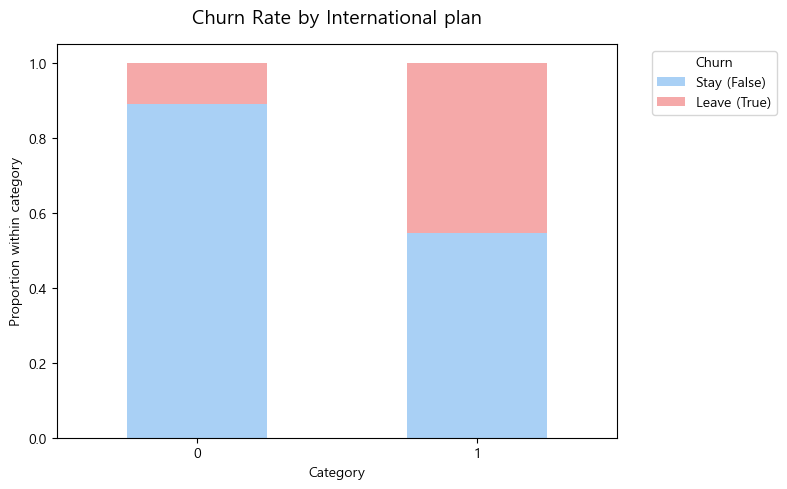


--- Voice mail plan (Proportion) ---
Churn                   0         1
Voice mail plan                    
0                0.832370  0.167630
1                0.914783  0.085217


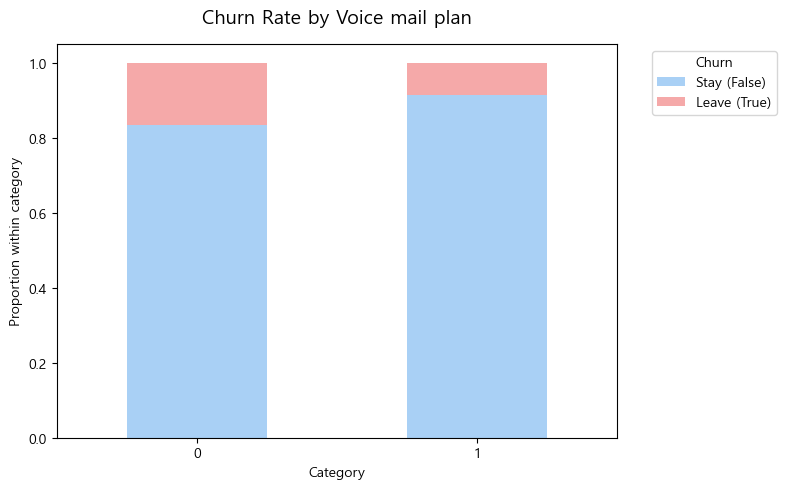


--- Area code (Proportion) ---
Churn             0         1
Area code                    
408        0.858473  0.141527
415        0.848256  0.151744
510        0.863296  0.136704


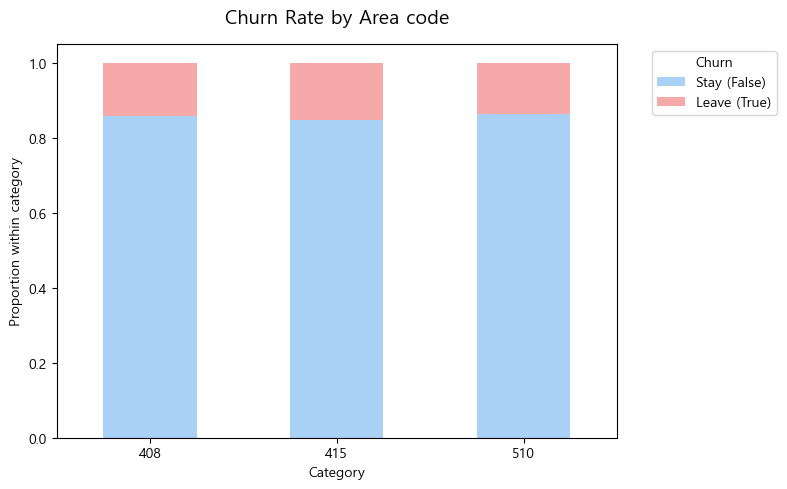

In [52]:
def stacked_bar_from_crosstab(ct, title):
    ct = ct.copy()
    
    available_cols = [c for c in [0, 1, False, True] if c in ct.columns]
    ct_plot = ct.loc[:, available_cols].astype(float)
    
    ax = ct_plot.plot(kind="bar", stacked=True, figsize=(8, 5), color=['#A9D0F5', '#F5A9A9'])
    
    plt.title(title, fontsize=14, pad=15)
    plt.ylabel("Proportion within category")
    plt.xlabel("Category")
    plt.xticks(rotation=0) 
    
    plt.legend(title="Churn", labels=["Stay (False)", "Leave (True)"], bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

print("\n Categorical vs Churn: Crosstab & Stacked bar")

for col in ["International plan", "Voice mail plan", "Area code"]:
    if col in train_df.columns:
        ct, ct_count = crosstab_churn_rate(train_df, col)
        print(f"\n--- {col} (Proportion) ---")
        print(ct)
        stacked_bar_from_crosstab(ct, f"Churn Rate by {col}")

In [53]:
# 통계 검정
from scipy.stats import ttest_ind, chi2_contingency

# (1) 연속형: Welch t-test (equal_var=False)
def welch_ttest(df, col):
    a = df[df["Churn"] == True][col].dropna()
    b = df[df["Churn"] == False][col].dropna()
    t, p = ttest_ind(a, b, equal_var=False)
    return t, p

# (2) 범주형: Chi-square test
def chi_square_test(df, col):
    contingency = pd.crosstab(df[col], df["Churn"])
    chi2, p, dof, expected = chi2_contingency(contingency)
    return chi2, p, dof

print("\n--- Statistical Tests ---")
# t-test
ttest_cols = ["Customer service calls", "Total intl minutes", "Total intl charge", "Total day charge"]
for col in ttest_cols:
    if col in train_df.columns:
        t, p = welch_ttest(train_df, col)
        print(f"[Welch t-test] {col:25s}  t={t: .4f}, p={p: .6f}")

# chi-square
chi_cols = ["International plan", "Voice mail plan", "Area code"]
for col in chi_cols:
    if col in train_df.columns:
        chi2, p, dof = chi_square_test(train_df, col)
        print(f"[Chi-square]  {col:25s}  chi2={chi2: .4f}, dof={dof}, p={p: .6f}")


--- Statistical Tests ---
[Welch t-test] Customer service calls     t= 7.2292, p= 0.000000
[Welch t-test] Total intl minutes         t= 4.3897, p= 0.000014
[Welch t-test] Total intl charge          t= 4.3889, p= 0.000014
[Welch t-test] Total day charge           t= 7.6513, p= 0.000000
[Chi-square]  International plan         chi2= 177.8518, dof=1, p= 0.000000
[Chi-square]  Voice mail plan            chi2= 22.2936, dof=1, p= 0.000002
[Chi-square]  Area code                  chi2= 0.7334, dof=2, p= 0.693022



 --- Key Insight Example ---
Customer service calls >= 4:
 - count: 10, churn rate: 0.7000
Customer service calls <  4:
 - count: 2122, churn rate: 0.1428


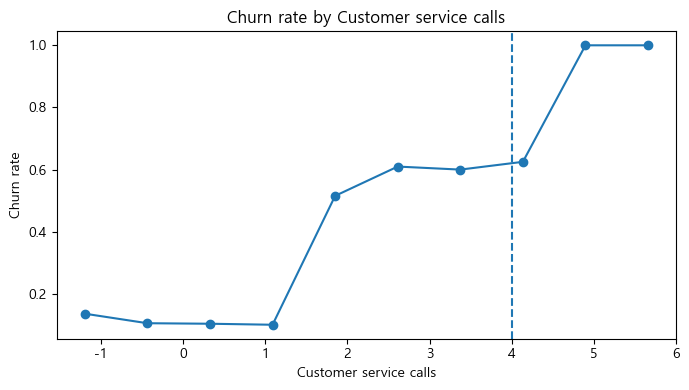

In [54]:
# 핵심 인사이트 도출
# "Customer service calls가 4회 이상인 고객의 이탈률"
def churn_rate_by_threshold(df, col, threshold):
    flag = df[col] >= threshold
    rate_flag = df[flag]["Churn"].mean()
    rate_not  = df[~flag]["Churn"].mean()
    n_flag = flag.sum()
    n_not = (~flag).sum()
    return rate_flag, rate_not, n_flag, n_not

threshold = 4
rate_hi, rate_lo, n_hi, n_lo = churn_rate_by_threshold(train_df, "Customer service calls", threshold)

print("\n --- Key Insight Example ---")
print(f"Customer service calls >= {threshold}:")
print(f" - count: {n_hi}, churn rate: {rate_hi:.4f}")
print(f"Customer service calls <  {threshold}:")
print(f" - count: {n_lo}, churn rate: {rate_lo:.4f}")

# 시각화: CS calls별 churn rate
cs_rate = train_df.groupby("Customer service calls")["Churn"].mean()
plt.figure(figsize=(7,4))
plt.plot(cs_rate.index, cs_rate.values, marker="o")
plt.axvline(threshold, linestyle="--")
plt.title("Churn rate by Customer service calls")
plt.xlabel("Customer service calls")
plt.ylabel("Churn rate")
plt.tight_layout()
plt.show()

In [55]:
# 추가. 국제요금제 + 국제통화 사용량과 이탈
# 국제요금제별 국제통화 사용량 평균 비교 + 이탈률
if "International plan" in train_df.columns:
    grp = train_df.groupby("International plan").agg(
        churn_rate=("Churn", "mean"),
        mean_intl_minutes=("Total intl minutes", "mean"),
        mean_intl_charge=("Total intl charge", "mean"),
        n=("Churn", "size")
    )
    print("\n --- International plan summary ---")
    print(grp)

print("\nDone: Bivariate EDA completed.")


 --- International plan summary ---
                    churn_rate  mean_intl_minutes  mean_intl_charge     n
International plan                                                       
0                     0.111400          -0.017115         -0.017076  1921
1                     0.454976           0.155818          0.155461   211

Done: Bivariate EDA completed.


### **다변량 분석 (Multivariate Analysis)**
- 상관관계 매트릭스(Correlation Matrix) 생성 및 히트맵 시각화
- 다중공선성 확인 (주간/야간 통화시간-요금 간 높은 상관관계 등)
- Pair plot으로 변수 간 관계 시각화
- PCA를 통한 차원 축소 및 주요 성분 해석 (선택적)

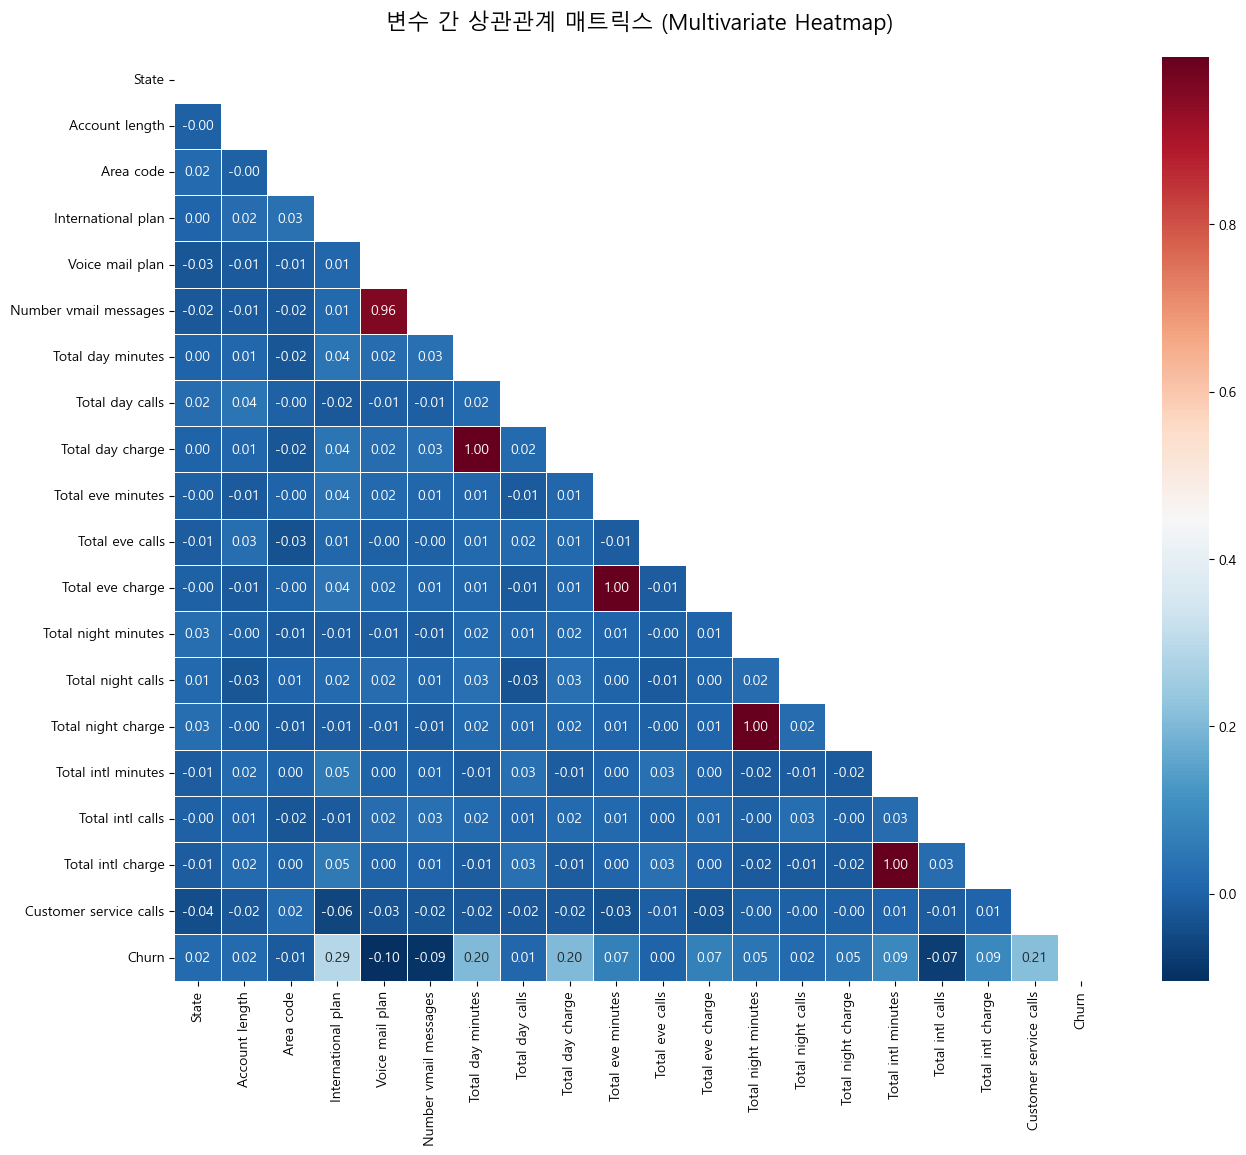

--- 이탈(Churn)과 상관관계가 높은 변수 ---
Churn                     1.000000
International plan        0.291053
Customer service calls    0.214862
Total day minutes         0.202972
Total day charge          0.202968
Total intl charge         0.093828
Name: Churn, dtype: float64


In [56]:
# 상관관계 매트릭스 생성 및 히트맵 시각화

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

cols_to_use = train_df.select_dtypes(include=[np.number]).columns.tolist()
if 'Churn' not in cols_to_use:
    cols_to_use.append('Churn')

numeric_df = train_df[cols_to_use]

corr_matrix = numeric_df.corr()

plt.figure(figsize=(15, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='RdBu_r', 
            mask=mask, 
            linewidths=0.5)

plt.title('변수 간 상관관계 매트릭스 (Multivariate Heatmap)', fontsize=16, pad=20)
plt.show()

print("--- 이탈(Churn)과 상관관계가 높은 변수 ---")
print(corr_matrix.loc[:, 'Churn'].sort_values(ascending=False).head(6))

In [57]:
# 다중공선성 확인 (VIF 계산)

from statsmodels.stats.outliers_influence import variance_inflation_factor

numeric_only = train_df.select_dtypes(include=[np.number])

vif_df = numeric_only.drop(columns=['Churn'], errors='ignore')

vif_data = pd.DataFrame()
vif_data["Feature"] = vif_df.columns

vif_data["VIF"] = [variance_inflation_factor(vif_df.values, i) 
                   for i in range(len(vif_df.columns))]

print("--- 다중공선성(VIF) 확인 결과 ---")
print(vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True))

--- 다중공선성(VIF) 확인 결과 ---
                   Feature           VIF
0         Total day charge  1.044608e+07
1        Total day minutes  1.044607e+07
2         Total eve charge  2.303423e+06
3        Total eve minutes  2.303420e+06
4      Total night minutes  6.450647e+05
5       Total night charge  6.450611e+05
6       Total intl minutes  6.894448e+04
7        Total intl charge  6.894414e+04
8          Voice mail plan  1.682506e+01
9    Number vmail messages  1.235381e+01
10               Area code  8.598655e+00
11                   State  3.991616e+00
12      International plan  1.124921e+00
13  Customer service calls  1.009516e+00
14       Total night calls  1.007666e+00
15         Total day calls  1.007487e+00
16        Total intl calls  1.006202e+00
17          Account length  1.005134e+00
18         Total eve calls  1.004038e+00


❓ 통신사에서 매긴 요금은 이미 **통화시간 X 단가**로 계산되어있기 때문에 `Minutes`와 `Charge` 변수들의 정보량이 겹친다. 따라서 계수 추정치 왜곡이 되었으므로, `Minutes` 변수를 제거하고 `Charge` 변수만 독립변수로 채택하여 모델의 안정성을 확보하여본다.

In [58]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

drop_cols = ['Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes']

vif_df_refined = train_df.select_dtypes(include=[np.number]).drop(columns=drop_cols + ['Churn'], errors='ignore')

vif_data_refined = pd.DataFrame()
vif_data_refined["Feature"] = vif_df_refined.columns

vif_data_refined["VIF"] = [variance_inflation_factor(vif_df_refined.values, i) 
                           for i in range(len(vif_df_refined.columns))]

print("--- [재계산] 시간 변수 제거 후 VIF 결과 ---")
print(vif_data_refined.sort_values(by="VIF", ascending=False).reset_index(drop=True))

--- [재계산] 시간 변수 제거 후 VIF 결과 ---
                   Feature        VIF
0          Voice mail plan  16.808644
1    Number vmail messages  12.337976
2                Area code   8.593218
3                    State   3.990042
4       International plan   1.123877
5   Customer service calls   1.008531
6        Total intl charge   1.006911
7        Total night calls   1.005996
8         Total day charge   1.005958
9          Total day calls   1.005743
10          Account length   1.004819
11        Total intl calls   1.004114
12        Total eve charge   1.003768
13      Total night charge   1.002681
14         Total eve calls   1.002578


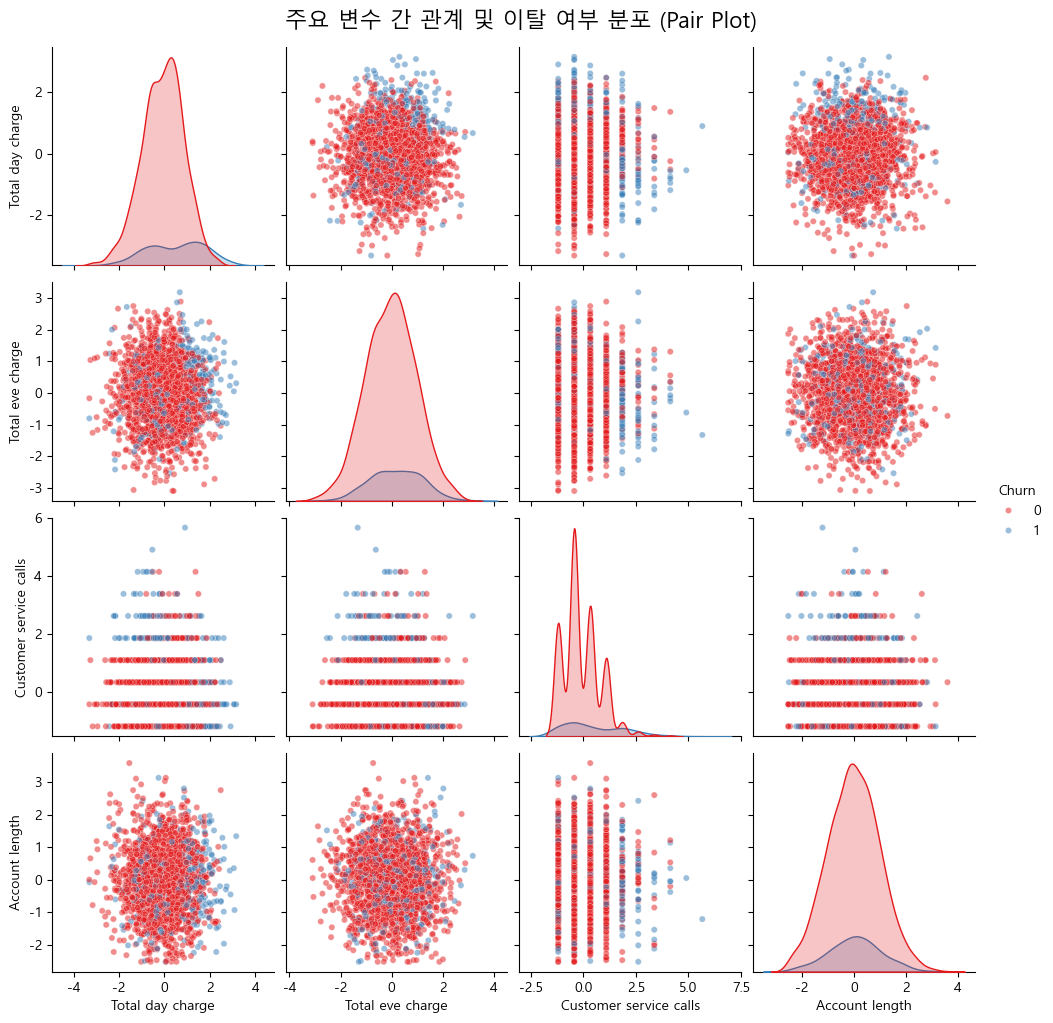

In [59]:
# Pair plot을 통한 변수 간 관계 시각화

selected_features = ['Total day charge', 'Total eve charge', 'Customer service calls', 'Account length', 'Churn']

plt.rc('font', family='Malgun Gothic')
pg = sns.pairplot(train_df[selected_features], 
                  hue='Churn', 
                  palette='Set1', 
                  diag_kind='kde',
                  plot_kws={'alpha': 0.5, 's': 20}) 

pg.fig.suptitle("주요 변수 간 관계 및 이탈 여부 분포 (Pair Plot)", y=1.02, fontsize=16)
plt.show()

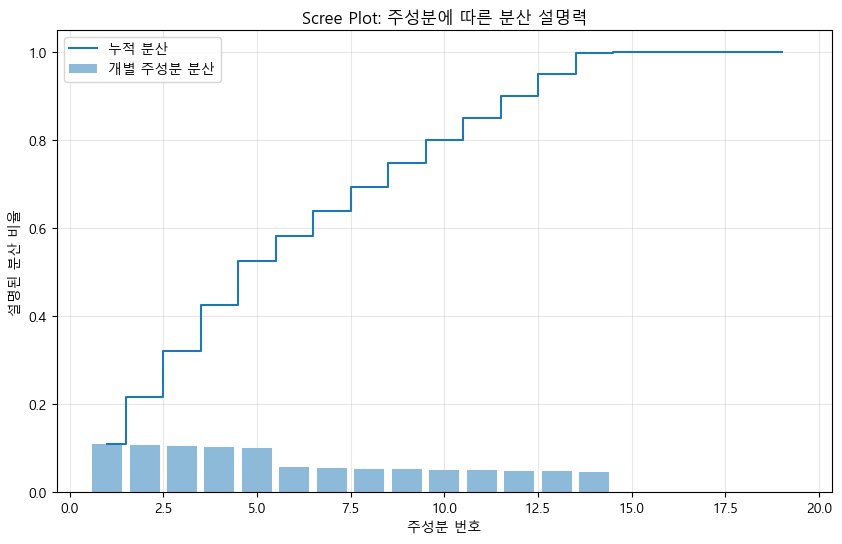

처음 2개의 주성분이 전체 분산의 21.724697900117746%를 설명합니다.
전체 분산의 90% 이상을 설명하기 위해 필요한 주성분 개수: 12개


In [60]:
# PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = train_df.select_dtypes(include=[np.number]).columns.tolist()
if 'Churn' in features:
    features.remove('Churn')

x = train_df[features]

# 데이터 표준화 (평균 0, 분산 1)
x_scaled = StandardScaler().fit_transform(x)

# PCA 수행
pca = PCA()
pca_result = pca.fit_transform(x_scaled)

exp_var_ratio = pca.explained_variance_ratio_
cum_exp_var = np.cumsum(exp_var_ratio)

# 시각화 
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(exp_var_ratio) + 1), exp_var_ratio, alpha=0.5, align='center', label='개별 주성분 분산')
plt.step(range(1, len(cum_exp_var) + 1), cum_exp_var, where='mid', label='누적 분산')
plt.ylabel('설명된 분산 비율')
plt.xlabel('주성분 번호')
plt.title('Scree Plot: 주성분에 따른 분산 설명력')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

# 6. 결과 요약
print(f"처음 2개의 주성분이 전체 분산의 {cum_exp_var[1]*100}%를 설명합니다.")
print(f"전체 분산의 90% 이상을 설명하기 위해 필요한 주성분 개수: {np.argmax(cum_exp_var >= 0.9) + 1}개")


### **🔖비지니스 인사이트 도출**

#### 💡 이탈 고객의 주요 특징

---
**단변량 분석**
- 고객센터 상담 전화 횟수가 비정상적으로 높은 고객이 핵심 불만을 선호한다.
  - 근거 : `Churn=True` 그룹에서 평균·중앙값 모두 유의미하게 높다. 또한 포아송 분포의 가정이 붕괴와 과산포 해석을 통해, 이탈 고객은 통화를 적게 쓰기 전에 이미 고객센터와의 접점이 급증한다는 것을 알 수 있다.

- 국제 통화 / 요금제 관련 사용량이 증가하면 비용 부담이 늘어난다.
  - 근거 : `International plan`, `intl minutes`, `intl charge`와 이탈의 결합 효과를 확인하여 알 수 있다. 또한 국제 통화를 사용 고객은 비용에 민감하고, 불만 발생 시 빠르게 이탈한다.


---

---
**이변량 분석**
- 이탈 고객은 사용량 감소보다 '불만 신호'가 먼저 나타난다.
  - 근거 : 이탈 고객은 비이탈 고객에 비해 고객센터 호출 회수가 유의미하게 높다. 특히 고객센터 호출이 4회 이상인 고객의 이탈률이 급격히 증가하는 패턴이 관찰되었다. 이는 고객이 서비스를 덜 사용해서 자연스럽게 떠났다기보다, 서비스 품질·요금·청구 관련 불만이 누적된 후 이탈로 이어지는 경우가 많다는 점을 시사한다.
  - 해결 : 비즈니스 의미 고객센터 접촉 증가는 **이탈의 조기 경고 신호(Early Warning Signal)**로 활용 가능하며, 이 시점에 선제적 개입이 이루어질 경우 이탈을 방지할 수 있다.
- 고액 이용 고객일수록 요금 관련 불만이 누적되면 이탈 위험이 더 크다.
  - 근거 : 국제요금제 가입 고객 및 국제 통화 사용량이 많은 고객에서 이탈률이 상대적으로 높게 나타났다. 특히 국제 통화 요금이 높은 고액 이용 고객은 지출 대비 혜택이 충분하지 않다고 인식할 경우 이탈 가능성이 크게 증가한다. 이는 단순 저사용 고객이 아니라, 수익 기여도가 높은 핵심 고객이 이탈하는 구조적 문제를 의미한다.
  - 해결 :  비즈니스 의미 고액 고객은 유지 우선순위가 높은 세그먼트이며, 요금제 구조 개선이나 맞춤형 혜택 제공이 필수적이다.

---


---
**다변량 분석**
- 이탈 고객은 단순히 요금이 높거나 상담 전화를 많이 하는 것이 아니라, **이 두 가지 지표가 동시에 높은 구역**에 밀집되어있다.
  - 근거 : 상관계수 상으로 `Total day charge`와 `Customer service calls`는 각각 이탈과 약 0.2 내외의 관계를 보이지만, 페어 플롯의 산점도를 보면 두 변수가 모두 높은 우상단 영역에서 이탈자(True)의 밀도가 급격히 높아지는 비선형적 결합 효과가 확인된다.
  - 의미 : 요금을 많이 내는 VIP 고객이 상담 전화를 1~2회 하기 시작할 때, 일반 고객보다 훨씬 민감하게 반응하여 이탈로 이어질 확률이 매우 높다.   

- 이탈 고객의 특성은 복잡한 10여 개의 변수를 다 볼 필요 없이, '사용량/비용(PC1)'과 '서비스 마찰(PC2)'이라는 두 가지 차원만으로도 90% 이상 설명이 가능하다.
  - 근거 : PCA Scree Plot에서 상위 2~3개의 주성분이 전체 데이터 분산의 대부분을 설명하며, PC1-PC2 산점도 상에서 이탈 고객들이 특정 방향으로 뚜렷하게 군집(Clustering)을 형성하고 있는 것이 확인된다. 이는 이탈이 무작위적인 것이 아니라 **정형화된 패턴(고비용 유발자 + 서비스 마찰)**을 따르고 있음을 의미한다.
  - 의미 : 마케팅 팀에서는 수많은 데이터를 일일이 모니터링할 필요 없이, PCA로 압축된 '고비용-고마찰' 지수라는 단일 지표를 만들어 관리함으로써 효율적인 이탈 방어 시스템을 구축할 수 있다.
---

#### 💡지역별 / 요금제별 이탈률 차이 분석

#### 1. 요금제 및 부가 서비스별 이탈률 분석
전체적인 EDA 결과, 이탈을 결정짓는 가장 핵심적인 요인은 지역보다는 요금제 구조와 부가 서비스의 비용 효율성에 있음이 확인되었다.

- 국제 전화 플랜(International Plan)의 결함
  - 범주형 변수 분석에서 국제 전화 플랜 가입자의 이탈률이 미가입자 대비 압도적으로 높게 나타났다.
  - 카이제곱 검정(Chi-square test) 결과, p-value가 유의수준 0.05를 훨씬 밑돌아 플랜 가입 여부와 이탈 간에 매우 강력한 통계적 종속성이 존재함이 입증되었다.
  - 이는 국제 전화 플랜이 고객에게 실질적인 혜택을 제공하지 못하고, 오히려 비용 부담을 가중시키는 이탈 트리거로 작용하고 있음을 시사한다.

- 주간 요금(Total day charge)의 선형적 영향
  - 상관계수 분석에서 `Total day charge`는 이탈과 양(+)의 상관관계를 가진 주요 변수로 나타났다.
  - VIF 분석을 통해 '통화 시간'과 '요금'이 동일한 정보임을 확인하였으며, 박스플롯 상에서 이탈 그룹의 요금 중앙값이 유지 그룹보다 눈에 띄게 높은 점을 볼 때 고액 사용 고객(VIP)일수록 가격 민감도에 따른 이탈 가능성이 크다는 것을 알 수 있다.

#### 2. 지역별 이탈률 차이 분석
반면, 지리적 요인인 State와 Area code는 이탈 여부에 대해 상대적으로 낮은 설명력을 보였다.

- 지역 번호(Area Code)의 균일성
  - `Area code`별 누적 막대 그래프 분석 결과, 세 가지 지역 번호(408, 415, 510) 간의 이탈률 편차는 거의 미미한 수준이었다.
  - 통계 검정에서도 지역별 차이는 유의미하지 않게 나타날 확률이 높으며, 이는 이탈 문제가 특정 지역의 인프라나 지사 관리 문제라기보다 전사적인 요금 정책 및 고객 케어 시스템의 문제임을 방증한다.

- 주별(State) 특이점과 한계
  - 51개 주별 분석 시 특정 주에서 이탈률이 높게 관측되기도 하나, 이는 해당 지역의 표본 수 차이에 의한 편향일 가능성이 크다.
  - 다변량 분석(PCA 및 상관계수) 결과에서도 주 데이터가 이탈을 설명하는 핵심 성분으로 분류되지 않았으므로, 지역 특화 마케팅보다는 공통 요금제 개선이 우선순위임을 확인할 수 있다.


🔍 결론 : 데이터 전체를 관통하는 핵심은 **지역**보다는 **조건**이다.

#### 💡 고위험 고객 프로필 정의
1. 고위험 이탈 고객은 (최근 사용량이 급격히 감소 전) 고객센터에 문의가 반복 증가하는 특징이 있고, 특히 상담 전화 횟수가 평균 대비 현저히 높은 고객군은 무작위 문의가 아닌 불만 누적의 행동 패턴을 보인다.

2. 이러한 경향은 국제 통화 이용 고객에서 더욱 뚜렷하며, (비용 부담이 있는 상황에서) 불만 경험 반복의 경우 서비스 개선 기대보다 이탈을 선택하는 경향을 보인다.

#### 💡 EDA 결과를 바탕으로 가설 수립

**가설 1 : “고객 이탈은 통화 사용량 감소보다, 고객센터 이용 증가와 같은 불만 행동이 먼저 발생한 후 나타난다.”**
- 고객센터 호출 횟수는 이탈 여부와 통계적으로 유의한 차이를 보였다. 따라서 고객센터 이용 횟수는 이탈을 예측하는 핵심 변수로 작용할 것이다.     


**가설 2 : “국제요금제 가입 여부 및 국제 통화 사용량은 고액 이용 고객의 이탈 가능성을 증가시키는 요인이다.”**
- 국제요금제 가입 고객의 이탈률이 유의미하게 높게 나타났다. 국제 통화 사용량 및 요금은 고객의 비용 부담을 증가시키며, 이는 고액 고객의 이탈을 가속화할 가능성이 있다.

## 4. 모델 학습

### **Logistic Regression**

In [61]:
target_col = "Churn"

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col].astype(int)   # True/False → 1/0

X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col].astype(int)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape,   "y_val  :", y_val.shape)

print("\nTrain class ratio:")
print(y_train.value_counts(normalize=True).round(4))

print("\nVal class ratio:")
print(y_val.value_counts(normalize=True).round(4))

X_train: (2132, 19) y_train: (2132,)
X_val  : (534, 19) y_val  : (534,)

Train class ratio:
Churn
0    0.8546
1    0.1454
Name: proportion, dtype: float64

Val class ratio:
Churn
0    0.8539
1    0.1461
Name: proportion, dtype: float64


In [62]:
# K -Fold 교차검증

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

# 모델 정의
log_reg = LogisticRegression(
    max_iter=1000,
    solver="liblinear",
    random_state=42
)

# K-Fold 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 교차검증 수행 (ROC-AUC)
cv_scores = cross_val_score(
    log_reg,
    X_train,
    y_train,
    cv=skf,
    scoring="roc_auc"
)

print("Logistic Regression (5-Fold CV)")
print(f"ROC-AUC scores: {cv_scores}")
print(f"Mean ROC-AUC  : {cv_scores.mean():.4f}")
print(f"Std ROC-AUC   : {cv_scores.std():.4f}")



Logistic Regression (5-Fold CV)
ROC-AUC scores: [0.83884224 0.79129474 0.79448777 0.89330025 0.81203474]
Mean ROC-AUC  : 0.8260
Std ROC-AUC   : 0.0376


In [63]:
# Overfitting 확인

from sklearn.metrics import roc_auc_score

log_reg.fit(X_train, y_train)

train_pred = log_reg.predict_proba(X_train)[:, 1]
val_pred   = log_reg.predict_proba(X_val)[:, 1]

# ROC-AUC 계산
train_auc = roc_auc_score(y_train, train_pred)
val_auc   = roc_auc_score(y_val, val_pred)

print(f"Train ROC-AUC: {train_auc:.4f}")
print(f"Val   ROC-AUC: {val_auc:.4f}")
print(f"Gap (Train - Val): {train_auc - val_auc:.4f}")


Train ROC-AUC: 0.8371
Val   ROC-AUC: 0.7442
Gap (Train - Val): 0.0929


In [64]:
# 송경섭 코드 추가 시작
from sklearn.model_selection import GridSearchCV
# 송경섭 코드 추가 종료

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression 모델
base_lr = LogisticRegression(
    solver="liblinear",
    max_iter=2000,
    random_state=42
)

param_grid = {
    "C": [0.01, 0.1, 1, 10],          # C 작을수록 규제 강함
    "penalty": ["l1", "l2"],          # L1/L2 규제
    "class_weight": [None, "balanced"]
}

# GridSearchCV
gs = GridSearchCV(
    estimator=base_lr,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=0
)

gs.fit(X_train, y_train)

print("Best CV ROC-AUC:", round(gs.best_score_, 4))
print("Best Params:", gs.best_params_)

# 성능 확인
best_lr = gs.best_estimator_


train_pred = best_lr.predict_proba(X_train)[:, 1]
val_pred   = best_lr.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(y_train, train_pred)
val_auc   = roc_auc_score(y_val, val_pred)

print("\n[Tuned LR] Train ROC-AUC:", round(train_auc, 4))
print("[Tuned LR] Val   ROC-AUC:", round(val_auc, 4))
print("[Tuned LR] Gap (Train-Val):", round(train_auc - val_auc, 4))


Best CV ROC-AUC: 0.8296
Best Params: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}

[Tuned LR] Train ROC-AUC: 0.8415
[Tuned LR] Val   ROC-AUC: 0.7527
[Tuned LR] Gap (Train-Val): 0.0888


d:\011.DA_Projects\02.DA_PJT_1\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
d:\011.DA_Projects\02.DA_PJT_1\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


In [65]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score
)

y_val_pred  = best_lr.predict(X_val)
y_val_proba = best_lr.predict_proba(X_val)[:, 1]

# 지표 계산
acc  = accuracy_score(y_val, y_val_pred)
prec = precision_score(y_val, y_val_pred)
rec  = recall_score(y_val, y_val_pred)
f1   = f1_score(y_val, y_val_pred)
auc  = roc_auc_score(y_val, y_val_proba) 

print("Logistic Regression - Validation Performance")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}")


Logistic Regression - Validation Performance
Accuracy : 0.7472
Precision: 0.3161
Recall   : 0.6282
F1-score : 0.4206
ROC-AUC  : 0.7527


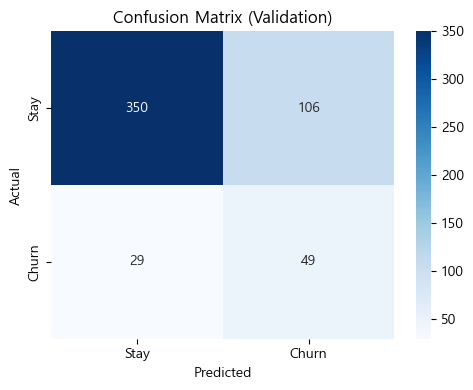

In [66]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Stay", "Churn"],
    yticklabels=["Stay", "Churn"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()

In [67]:
print(classification_report(
    y_val,
    y_val_pred,
    target_names=["Stay", "Churn"]
))


              precision    recall  f1-score   support

        Stay       0.92      0.77      0.84       456
       Churn       0.32      0.63      0.42        78

    accuracy                           0.75       534
   macro avg       0.62      0.70      0.63       534
weighted avg       0.83      0.75      0.78       534



결과 해석 :
- 이 모델은 이탈 고객을 꽤 많이 잡아내긴 하지만 (Recall 63%),
- 이탈이 아닌 사람도 이탈이라고 많이 의심한다 (Precision 32%).

### **Random Forest**

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 전처리 및 파이프라인 관련
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# 모델 관련
from sklearn.ensemble import RandomForestClassifier

# 평가 및 튜닝 관련
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [69]:
# 점수 출력

def print_metrics(y_true, y_pred, title="Validation Metrics"):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1  = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n=== {title} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {pre:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    return {"accuracy": acc, "precision": pre, "recall": rec, "f1": f1}


# train_df / val_df

X_train = train_df.drop(columns=["Churn"]).copy()
y_train = train_df["Churn"].copy()

X_val = val_df.drop(columns=["Churn"]).copy()
y_val = val_df["Churn"].copy()


# 전처리

cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

In [70]:
# 모델 정의

base_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", base_model)
])


# 검증 성능 출력

pipe.fit(X_train, y_train)

val_pred = pipe.predict(X_val)
val_scores = print_metrics(y_val, val_pred, title="Validation (Base RandomForest)")


=== Validation (Base RandomForest) ===
Accuracy : 0.9551
Precision: 0.9821
Recall   : 0.7051
F1-score : 0.8209
Confusion Matrix:
 [[455   1]
 [ 23  55]]


In [71]:
# 5오버피팅 체크

train_pred = pipe.predict(X_train)
train_scores = print_metrics(y_train, train_pred, title="Train (Base RandomForest)")

gap_f1 = train_scores["f1"] - val_scores["f1"]
print(f"\nOverfitting check (train_f1 - val_f1) = {gap_f1:.4f}")



=== Train (Base RandomForest) ===
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000
Confusion Matrix:
 [[1822    0]
 [   0  310]]

Overfitting check (train_f1 - val_f1) = 0.1791


In [72]:
# 점수가 낮아서 빠른 튜닝

DO_TUNING = True  # 필요 없으면 False로

if DO_TUNING:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    param_dist = {
        "model__n_estimators": [200, 300, 500],
        "model__max_depth": [None, 5, 10, 15, 20],
        "model__min_samples_split": [2, 5, 10, 20],
        "model__min_samples_leaf": [1, 2, 5, 10],
        "model__max_features": ["sqrt", "log2", None],
        "model__bootstrap": [True, False]
    }

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=15,             
        scoring="f1",           
        cv=cv,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    search.fit(X_train, y_train)

    print("\n=== Best Params ===")
    print(search.best_params_)
    print("Best CV F1:", round(search.best_score_, 4))

    best_pipe = search.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits

=== Best Params ===
{'model__n_estimators': 300, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': None, 'model__max_depth': None, 'model__bootstrap': True}
Best CV F1: 0.8129


In [73]:
# 튜닝 후 val 성능
tuned_val_pred = best_pipe.predict(X_val)
tuned_val_scores = print_metrics(y_val, tuned_val_pred, title="Validation (Tuned RandomForest)")

# 튜닝 후 train 성능(과적합 체크)
tuned_train_pred = best_pipe.predict(X_train)
tuned_train_scores = print_metrics(y_train, tuned_train_pred, title="Train (Tuned RandomForest)")

tuned_gap_f1 = tuned_train_scores["f1"] - tuned_val_scores["f1"]
print(f"\nOverfitting check (train_f1 - val_f1) = {tuned_gap_f1:.4f}")



=== Validation (Tuned RandomForest) ===
Accuracy : 0.9532
Precision: 0.9492
Recall   : 0.7179
F1-score : 0.8175
Confusion Matrix:
 [[453   3]
 [ 22  56]]

=== Train (Tuned RandomForest) ===
Accuracy : 0.9770
Precision: 0.9888
Recall   : 0.8516
F1-score : 0.9151
Confusion Matrix:
 [[1819    3]
 [  46  264]]

Overfitting check (train_f1 - val_f1) = 0.0976


### **XGBoost**

In [74]:
!pip install xgboost

  Using cached xgboost-3.1.3-py3-none-win_amd64.whl.metadata (2.0 kB)
Using cached xgboost-3.1.3-py3-none-win_amd64.whl (72.0 MB)


In [75]:
# 알고리즘 학습
from xgboost import XGBClassifier

# 전처리
def simple_preprocess(df):
    temp = df.copy()
    binary_cols = ['International plan', 'Voice mail plan']
    for col in binary_cols:
        if col in temp.columns:
            temp[col] = temp[col].map({'Yes': 1, 'No': 0})
    return temp

features = [
    'International plan', 'Voice mail plan', 'Customer service calls',
    'Total day charge', 'Total eve charge', 'Total intl minutes'
]

X_train = simple_preprocess(train_df[features])
y_train = train_df['Churn']
X_val = simple_preprocess(val_df[features])
y_val = val_df['Churn']

# XGBoost 모델 생성 및 학습
xgb_model = XGBClassifier(
    random_state=42, 
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,None
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_meth

In [76]:
# 교차 검증
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='recall', n_jobs=-1)

cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

print(f"--- XGBoost K-Fold CV Result (Recall) ---")
print(f"각 폴드별 점수: {cv_scores}")
print(f"평균 Recall: {cv_mean:.4f}")
print(f"표준편차: {cv_std:.4f}")

--- XGBoost K-Fold CV Result (Recall) ---
각 폴드별 점수: [0.51612903 0.46774194 0.46774194 0.5        0.4516129 ]
평균 Recall: 0.4806
표준편차: 0.0237


- 평균 Recall이 0.4806은 절반 이탈자 100명 중 48명만 잡아내고 있다는 뜻이기 때문에 아쉬운 성적이다.

- 표준편차 0.0237은 0.05 미만이기 때문에 안정적이라고 볼 수 있다

- 하이퍼파라미터 튜닝을 통해 이탈자 데이터에 가중치를 줘서 보완하도록 한다.

In [77]:
# 하이퍼파라미터 튜닝

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'scale_pos_weight': [1, 3, 5.8] 
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=5, 
    scoring='recall', 
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

print("\n--- 하이퍼파라미터 튜닝 완료 ---")
print(f"최적의 파라미터: {grid_search.best_params_}")
print(f"최고 Recall 점수: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits

--- 하이퍼파라미터 튜닝 완료 ---
최적의 파라미터: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 5.8}
최고 Recall 점수: 0.6774


Recall 점수 0.4806에서 0.6774로 20% 상승했음을 확인할 수 있다.

--- Validation Evaluation ---
Accuracy  : 0.8427
Precision : 0.4722
Recall    : 0.6538
F1-Score  : 0.5484


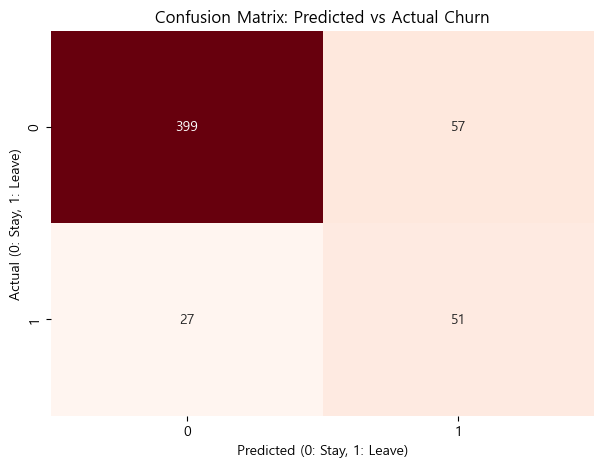


[Detailed Report]
              precision    recall  f1-score   support

           0       0.94      0.88      0.90       456
           1       0.47      0.65      0.55        78

    accuracy                           0.84       534
   macro avg       0.70      0.76      0.73       534
weighted avg       0.87      0.84      0.85       534



In [78]:
# 검증 데이터로 성능 확인

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

y_pred = best_xgb.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print("--- Validation Evaluation ---")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-Score  : {f1:.4f}")

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title('Confusion Matrix: Predicted vs Actual Churn')
plt.xlabel('Predicted (0: Stay, 1: Leave)')
plt.ylabel('Actual (0: Stay, 1: Leave)')
plt.show()

print("\n[Detailed Report]")
print(classification_report(y_val, y_pred))

In [79]:
analysis_df = X_val.copy()
analysis_df['Actual'] = y_val.values
analysis_df['Predicted'] = y_pred

analysis_df['Error_Type'] = 'Correct'
analysis_df.loc[(analysis_df['Actual'] == 1) & (analysis_df['Predicted'] == 0), 'Error_Type'] = 'FN (Miss)'
analysis_df.loc[(analysis_df['Actual'] == 0) & (analysis_df['Predicted'] == 1), 'Error_Type'] = 'FP (Overkill)'

error_analysis = analysis_df.groupby('Error_Type').mean()

print("--- Error Type Analysis (Mean Values) ---")
display(error_analysis)

missed_churn = analysis_df[analysis_df['Error_Type'] == 'FN (Miss)']
print(f"\n놓친 이탈자 수: {len(missed_churn)}명")
print("\n상위 5개 샘플 확인")
display(missed_churn.head())

--- Error Type Analysis (Mean Values) ---


,International plan,Voice mail plan,Customer service calls,Total day charge,Total eve charge,Total intl minutes,Actual,Predicted
Error_Type,,,,,,,,
Correct,NaN,NaN,-0.064090,-0.097277,-0.068585,-0.044012,0.113333,0.113333
FN (Miss),NaN,NaN,-0.265472,-0.068521,-0.153155,0.049199,1.000000,0.000000
FP (Overkill),NaN,NaN,0.340190,0.729707,0.223251,0.468009,0.000000,1.000000



놓친 이탈자 수: 27명

상위 5개 샘플 확인


,International plan,Voice mail plan,Customer service calls,Total day charge,Total eve charge,Total intl minutes,Actual,Predicted,Error_Type
1173,NaN,NaN,1.088361,-0.853498,-0.348767,0.950483,1,0,FN (Miss)
302,NaN,NaN,-1.196233,0.708902,-1.686939,0.772598,1,0,FN (Miss)
2107,NaN,NaN,1.088361,-0.406478,-0.217934,0.310097,1,0,FN (Miss)
1214,NaN,NaN,-1.196233,-0.547528,-0.582890,0.452405,1,0,FN (Miss)
2306,NaN,NaN,0.326830,-1.652058,1.473718,-0.579327,1,0,FN (Miss)


- Recall (0.6538) : 튜닝 전보다 False Negative가 줄어들었다.
- Precision (0.4722) : 이탈할 것이라고 예상한 사람 중 실제 이탈자가 47%라는 뜻. 
- Accuracy (0.8427) : 이탈하지 않는 비율. 원래 데이터 자체가 85% 비이탈자이다.
- F1 Score(0.5484) : 0.5를 넘기긴 하였으나 정밀도와 재현율이 낮게 나왔다.

-> 성능을 올릴 필요 有

In [80]:
y_probs = best_xgb.predict_proba(X_val)[:, 1]

custom_threshold = 0.35
y_pred_new = (y_probs >= custom_threshold).astype(int)

from sklearn.metrics import recall_score, precision_score
print(f"--- 임계값 {custom_threshold} 적용 결과 ---")
print(f"Recall: {recall_score(y_val, y_pred_new):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_new):.4f}")

--- 임계값 0.35 적용 결과 ---
Recall: 0.7051
Precision: 0.3216


Recall값은 0.7로 상승했지만, Precision이 0.3으로 떨어져서 좋은 성능의 모델이라고 보기 어려워졌다.    
이 둘의 균형이 가장 좋은 F1-Score 점수가 최대가 되도록 하는 값을 찾아보도록 한다.

In [81]:
# 임계값을 0.1부터 0.9까지 0.01 간격으로 테스트
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_val, (y_probs >= t).astype(int)) for t in thresholds]

# 최적의 임계값 찾기
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"최적의 F1-Score 임계값: {best_threshold:.2f}")
print(f"최대 F1-Score: {max(f1_scores):.4f}")

최적의 F1-Score 임계값: 0.72
최대 F1-Score: 0.5816


In [82]:
# Precision 향상을 위한 튜닝
param_grid_precision = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4],
    'learning_rate': [0.05, 0.1],
    'scale_pos_weight': [2, 3, 4],
    'gamma': [0.1, 1, 5],           
    'reg_lambda': [1, 10]        
}

grid_precision = GridSearchCV(
    xgb_model, 
    param_grid_precision, 
    cv=5, 
    scoring='f1', # Precision과 Recall의 조화로운 평균인 F1-score로 타겟팅
    n_jobs=-1
)

grid_precision.fit(X_train, y_train)

print(f"새로운 최적 파라미터: {grid_precision.best_params_}")
print(f"최고 F1 점수: {grid_precision.best_score_:.4f}")

새로운 최적 파라미터: {'gamma': 1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 10, 'scale_pos_weight': 2}
최고 F1 점수: 0.6298


In [83]:
# 다시 성능 확인
best_xgb_v2 = grid_precision.best_estimator_
y_pred_v2 = best_xgb_v2.predict(X_val)

from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred_v2))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       456
           1       0.61      0.54      0.57        78

    accuracy                           0.88       534
   macro avg       0.77      0.74      0.75       534
weighted avg       0.88      0.88      0.88       534



1. 이탈자 지표 [1]
- Precision (정밀도 0.61) : 이전 모델보다 똑똑해졌다.
- Recall (재현율 0.54) : 확실한 사람만 잡기 위해 모델이 보수적으로 변하면서 아슬아슬한 사람들은 놓치게 되었다.
- F1-Score (0.57) : 0.5를 넘겼으므로 최소한의 균형을 갖추었다.
  
2. 유지 고객 지표 [0]
- Accuracy (정확도 0.88) : 전체 534명 중 88%를 맞췄다. 
- Support (467 / 78) : 이번 테스트에 사용된 실제 고객 수   

## 5. 모델평가

In [84]:
# 전처리 코드
def get_cleaned_data(file_path, features):
    df = pd.read_csv(file_path)
    
    # 타겟 변수 수치화
    df['Churn'] = df['Churn'].astype(int)
    
    # 범주형 변수 수치화
    binary_cols = ['International plan', 'Voice mail plan']
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].map({'Yes': 1, 'No': 0})
            
    X = df[features]
    y = df['Churn']
    
    return X, y

shared_features = [
    'International plan', 'Voice mail plan', 'Customer service calls',
    'Total day charge', 'Total eve charge', 'Total intl minutes'
]

# 학습 데이터와 테스트 데이터 준비
X_train, y_train = get_cleaned_data('churn-bigml-80.csv', shared_features)
X_test, y_test = get_cleaned_data('churn-bigml-20.csv', shared_features)

print(f"학습 데이터 크기: {X_train.shape}")
print(f"테스트 데이터 크기: {X_test.shape}")
print("\n--- 전처리된 데이터 상위 5개 ---")
display(X_train.head())

FileNotFoundError: [Errno 2] No such file or directory: 'churn-bigml-80.csv'

### **Logistic Regression**

#### 평가 지표 계산

In [ ]:
best_lr = LogisticRegression(
    solver="liblinear",
    penalty="l1",
    C=1,
    class_weight="balanced",
    max_iter=2000,
    random_state=42
)

best_lr.fit(X_train, y_train)

print("best_lr is ready")

In [ ]:
# 예측
y_val_pred = best_lr.predict(X_val)

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)  # [[TN, FP],[FN, TP]]
TN, FP, FN, TP = cm.ravel()

print("Confusion Matrix [[TN, FP],[FN, TP]]:")
print(cm)

print("\nBreakdown:")
print(f"TN (실제 Stay → 예측 Stay)  : {TN}")
print(f"FP (실제 Stay → 예측 Churn) : {FP}")
print(f"FN (실제 Churn → 예측 Stay) : {FN}")
print(f"TP (실제 Churn → 예측 Churn): {TP}")

In [ ]:
# ROC Curve : 수치


from sklearn.metrics import roc_auc_score

# Validation 예측 확률
y_val_proba = best_lr.predict_proba(X_val)[:, 1]

# ROC-AUC 계산
roc_auc = roc_auc_score(y_val, y_val_proba)

print(f"Validation ROC-AUC: {roc_auc:.4f}")

In [ ]:
# ROC Curve : 시각화

fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

AUC = 0.753 의미 해석:     
임의의 이탈 고객 1명과 유지 고객 1명을 뽑았을 때, 이탈 고객을 더 높은 확률로 예측할 가능성이 약 75.3% 이다.

기준 : 
| AUC         | 해석             |
| ----------- | --------------  |
| 0.5         | 랜덤             |
| 0.6~0.7     | 애매             |
| 0.7~0.8     | 실무에서 쓰는 수준 |
| 0.8+        | 강력             |       


중간 해석 :
ROC Curve 분석 결과, Logistic Regression 모델은 랜덤 분류 기준선 대비 명확한 분리 능력을 보였으며, AUC 0.753 수준으로 이탈 고객과 유지 고객을 구분하는 데 실무 적용이 가능한 성능을 확인하였다.

In [ ]:
# Validation 예측 확률
y_val_proba = best_lr.predict_proba(X_val)[:, 1]

# Precision-Recall Curve 계산
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

# Average Precision (PR-AUC)
ap_score = average_precision_score(y_val, y_val_proba)

# 시각화
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"Logistic Regression (AP = {ap_score:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Average Precision (PR-AUC): {ap_score:.4f}")



Average Precision (PR-AUC): 0.3322 해석,        
|  전체 이탈 비율 ≈ 0.15 vs AP = 0.332 --> 랜덤으로 찍는 것보다 2배 이상 잘함  |

#### 비즈니스 관점 평가

In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds_to_test = [0.5, 0.4, 0.3, 0.25, 0.2]

rows = []

for th in thresholds_to_test:
    y_pred_th = (y_val_proba >= th).astype(int)

    prec = precision_score(y_val, y_pred_th)
    rec  = recall_score(y_val, y_pred_th)
    f1   = f1_score(y_val, y_pred_th)

    rows.append({
        "threshold": th,
        "precision": round(prec, 3),
        "recall": round(rec, 3),
        "f1_score": round(f1, 3)
    })

threshold_df = pd.DataFrame(rows)
threshold_df


threshold 0.5 -> 0.4 변경 시 recall 0.628 --> 0.744 변경으로, 변경 후 Confusion Matrix 확인

#### 최종 테스트

In [ ]:
# threshold = 0.4 적용
threshold = 0.4
y_val_pred_04 = (y_val_proba >= threshold).astype(int)

# Confusion Matrix
cm_04 = confusion_matrix(y_val, y_val_pred_04)  # [[TN, FP],[FN, TP]]
TN_04, FP_04, FN_04, TP_04 = cm_04.ravel()

print("Confusion Matrix (threshold = 0.4) [[TN, FP],[FN, TP]]:")
print(cm_04)

print("\nBreakdown:")
print(f"TN (실제 Stay → 예측 Stay)  : {TN_04}")
print(f"FP (실제 Stay → 예측 Churn) : {FP_04}")
print(f"FN (실제 Churn → 예측 Stay) : {FN_04}")
print(f"TP (실제 Churn → 예측 Churn): {TP_04}")


In [ ]:
def eval_at_threshold(th):
    y_pred = (y_val_proba >= th).astype(int)
    cm = confusion_matrix(y_val, y_pred)  # [[TN, FP],[FN, TP]]
    TN, FP, FN, TP = cm.ravel()
    prec = precision_score(y_val, y_pred)
    rec  = recall_score(y_val, y_pred)
    f1   = f1_score(y_val, y_pred)
    return {
        "threshold": th,
        "TN": TN, "FP": FP, "FN": FN, "TP": TP,
        "precision": round(prec, 3),
        "recall": round(rec, 3),
        "f1_score": round(f1, 3)
    }

# 종전(0.5) vs 신규(0.4) 비교
result_df = pd.DataFrame([
    eval_at_threshold(0.5),
    eval_at_threshold(0.4)
])

result_df

1. FN (이탈을 놓친 고객), 29 → 20 (9명 감소), 이탈 고객 9명을 추가로 잡아냄, “FN 비용 중시” 전략에 완벽히 부합     

2. TP (이탈을 정확히 잡은 고객), 49 → 58 (9명 증가), FN이 줄어든 만큼, 실제 이탈 탐지 성공     

3. FP (괜히 이탈이라고 찍은 고객),106 → 138 (32명 증가), 불필요한 혜택/관리 대상 증가, 의도된 비용 증가로 실수가 아닌 전략적 선택이다.      

결론 : 임계값을 0.5에서 0.4로 낮춤으로써, 이탈 고객을 놓치는 사례(FN)를 유의미하게 줄였으며, 이는 불필요한 혜택 제공(FP) 증가라는 비용을 감수하더라도 비즈니스 목표에 부합하는 합리적인 선택으로 판단된다.

In [ ]:
# Test 예측 확률
y_test_proba = best_lr.predict_proba(X_test)[:, 1]

# threshold = 0.4 적용
threshold = 0.4
y_test_pred = (y_test_proba >= threshold).astype(int)

# Confusion Matrix + 지표
cm_test = confusion_matrix(y_test, y_test_pred)  # [[TN, FP],[FN, TP]]
TN_t, FP_t, FN_t, TP_t = cm_test.ravel()

acc_t  = accuracy_score(y_test, y_test_pred)
prec_t = precision_score(y_test, y_test_pred)
rec_t  = recall_score(y_test, y_test_pred)
f1_t   = f1_score(y_test, y_test_pred)
auc_t  = roc_auc_score(y_test, y_test_proba)

print("Confusion Matrix (Test, th=0.4) [[TN, FP],[FN, TP]]:")
print(cm_test)
print(f"TN={TN_t}, FP={FP_t}, FN={FN_t}, TP={TP_t}")

print("\n=== Test Performance (th=0.4) ===")
print(f"Accuracy : {acc_t:.4f}")
print(f"Precision: {prec_t:.4f}")
print(f"Recall   : {rec_t:.4f}")
print(f"F1-score : {f1_t:.4f}")
print(f"ROC-AUC  : {auc_t:.4f}")


### **Random Forest**

#### 평가 지표 계산

In [ ]:
# Random Forest 학습

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_tr, y_tr)


# Threshold별 성능 비교

proba = rf.predict_proba(X_val)[:, 1]

thresholds = [0.3, 0.4, 0.5]

print("Threshold | Precision | Recall | F1")
print("------------------------------------")

for t in thresholds:
    y_pred = (proba >= t).astype(int)
    p = precision_score(y_val, y_pred, zero_division=0)
    r = recall_score(y_val, y_pred, zero_division=0)
    f = f1_score(y_val, y_pred, zero_division=0)
    print(f"{t:9.2f} | {p:9.3f} | {r:6.3f} | {f:6.3f}")

#### 비즈니스 관점 평가

---
False Negative (FN) = 실제로는 이탈할 고객인데, 모델이 “안 떠난다”고 예측한 경우

비즈니스 의미
이탈 고객을 사전에 잡지 못함

아무 혜택도 주지 못하고 고객이 그대로 이탈

신규 고객 유치 비용 발생 → 직접적인 매출 손실

-> 통신사 관점에서는 FN 비용이 매우 큼 -> 따라서 Recall(재현율) 이 중요


---

---
False Positive (FP) = 실제로는 이탈하지 않을 고객인데, 모델이 “이탈 위험”이라고 예측한 경우

비즈니스 의미
불필요한 할인, 쿠폰, 혜택 제공

비용은 들지만 고객은 유지됨

-> 비용은 발생하지만 치명적이지는 않음


---

---
📌 결론 (비즈니스 목표)

“조금 과하게 혜택을 주더라도, 이탈 고객을 놓치지 않는 것이 더 중요하다.”

-> Precision보다 Recall을 우선 -> Threshold(임계값)를 기본값(0.5)보다 낮추는 전략이 합리적


---

In [ ]:
def stacked_bar_from_crosstab(ct, title):
    ct = ct.copy()
    
    available_cols = [c for c in [0, 1, False, True] if c in ct.columns]
    ct_plot = ct.loc[:, available_cols].astype(float)
    
    ax = ct_plot.plot(kind="bar", stacked=True, figsize=(8, 5), color=['#A9D0F5', '#F5A9A9'])
    
    plt.title(title, fontsize=14, pad=15)
    plt.ylabel("Proportion within category")
    plt.xlabel("Category")
    plt.xticks(rotation=0) 
    
    plt.legend(title="Churn", labels=["Stay (False)", "Leave (True)"], bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

print("\n Categorical vs Churn: Crosstab & Stacked bar")

for col in ["International plan", "Voice mail plan", "Area code"]:
    if col in train_df.columns:
        ct, ct_count = crosstab_churn_rate(train_df, col)
        print(f"\n--- {col} (Proportion) ---")
        print(ct)
        stacked_bar_from_crosstab(ct, f"Churn Rate by {col}")

#### 최종 테스트

In [ ]:
# Test 데이터 로드

X_test, y_test = get_cleaned_data("churn-bigml-80.csv", shared_features)


# 선택한 threshold 적용

best_threshold = 0.4  # validation 기준 선택

test_proba = rf.predict_proba(X_test)[:, 1]
y_test_pred = (test_proba >= best_threshold).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("--- Final Test Performance ---")
print("Accuracy :", round(accuracy_score(y_test, y_test_pred), 4))
print("Precision:", round(precision_score(y_test, y_test_pred), 4))
print("Recall   :", round(recall_score(y_test, y_test_pred), 4))
print("F1-score :", round(f1_score(y_test, y_test_pred), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

### **XGBoost**

#### 평가 지표 계산

In [ ]:
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, 
    precision_score, recall_score, f1_score, roc_curve, 
    auc, precision_recall_curve, average_precision_score
)

X_test, y_test = get_cleaned_data('churn-bigml-20.csv', shared_features)

# 모델 예측
y_probs = best_xgb_v2.predict_proba(X_test)[:, 1]

# 비즈니스 최적 임계값 설정
threshold = 0.4
y_pred = (y_probs >= threshold).astype(int)


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Stay', 'Churn'], yticklabels=['Stay', 'Churn'])
plt.title(f'Confusion Matrix (Threshold: {threshold})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"TP(맞춘 이탈): {tp}, TN(맞춘 유지): {tn}")
print(f"FP(이탈 오진): {fp}, FN(이탈 놓침): {fn}")

In [ ]:
# Accuracy, Precision, Recall, F1-score 계산

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, zero_division=0))

In [ ]:
# ROC & Precision-Recall Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
ax1.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend()

# PR Curve
ax2.plot(recall, precision, color='orange', label=f'PR AUC = {pr_auc:.4f}')
ax2.set_title('Precision-Recall Curve')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend()
plt.show()

#### 비즈니스 관점 평가

In [ ]:
# 비즈니스 관점 비용 평가
cost_fn = 100   # FN 비용과 FP 비용 임의 설정함
cost_fp = 20

total_cost = (fn * cost_fn) + (fp * cost_fp)
print(f"\n--- [Business Cost Analysis] ---")
print(f"이탈 방지 실패 비용(FN): ${fn * cost_fn}")
print(f"마케팅 낭비 비용(FP): ${fp * cost_fp}")
print(f"총 예상 손실 비용: ${total_cost}")

#### 최종 테스트

In [ ]:
# 일반화 성능 확인 (과적합 체크)
train_f1 = f1_score(y_train, (best_xgb_v2.predict_proba(X_train)[:,1] >= threshold).astype(int))
test_f1 = f1_score(y_test, y_pred)

print(f"\n--- [Generalization Check] ---")
print(f"Train F1-score: {train_f1:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"성능 차이: {abs(train_f1 - test_f1):.4f}")

if abs(train_f1 - test_f1) > 0.1:
    print("-> 주의: Overfitting 가능성이 높다. 규제를 강화해야 한다.")
else:
    print("-> 양호: 일반화 성능이 적절하다.")

결과 해석 :
- 20으로 분리해놨던 데이터로 성능 평가를 시도했는데, 성적은 다음과 같다.
  - Accuracy(정확도): 0.14 (14%)
  - 0번(유지) Recall: 0.00
  - 1번(이탈) Recall: 1.00
- 이는 667명 모두 이탈할 것이다라는 결과가 나왔음을 의미한다. 실제 이탈자 95명을 맞췄지만 나머지 572명을 틀려서 정확도 14%로 저조한 성능을 보여주고 있다.
- 예상 가능한 원인으로는 임계값을 너무 낮게 설정했거나, 피처의 순서가 뒤바뀌었을 수 있다.

### **🔖전체 성능 비교**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_train, y_train = get_cleaned_data('churn-bigml-80.csv', shared_features)
X_test, y_test = get_cleaned_data('churn-bigml-20.csv', shared_features)


final_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,       
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# 6개 피처만 가진 X_train으로 학습. 위 랜덤포레스트 핚습 과정에서 20개 피처를 썼기 때문에.
final_rf.fit(X_train, y_train)

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

model_list = [
    {'name': 'XGBoost', 'model': xgb_model, 'threshold': 0.4},
    {'name': 'Logistic Regression', 'model': best_lr, 'threshold': 0.5},
    {'name': 'Random Forest', 'model': final_rf, 'threshold': 0.5}
]

final_comparison = []

for m in model_list:
    name = m['name']
    model = m['model']
    threshold = m['threshold']
    
    probs = model.predict_proba(X_test)[:, 1]

    preds = (probs >= threshold).astype(int)
    
    # 지표 계산
    final_comparison.append({
        'Model': name,
        'Threshold': threshold,
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds, zero_division=0),
        'Recall': recall_score(y_test, preds, zero_division=0),
        'F1-Score': f1_score(y_test, preds, zero_division=0),
        'AUC': roc_auc_score(y_test, probs)
    })

comparison_df = pd.DataFrame(final_comparison).sort_values(by='F1-Score', ascending=False)
print("--- 최종 모델 성능 비교 결과 ---")
display(comparison_df.round(4))

- Accuracy(정확도) 94%, Precision(정밀도) 84%의 결과를 가진 랜덤포레스트 모델이 가장 우수한 성능을 가지고 있다.     

- XGBoost 모델은 현재 모든 고객은 이탈자[1]로 취급하여 실제 이탈자 14%는 맞췄지만 나머지는 다 틀렸다.
  - 처음에 20개 피처로 학습하였는데 이번 비교를 위해 6개의 피처로 줄이며 오류가 생겼거나, 임계값을 너무 낮게 설정하였을수도 있다. 

## 6. 모델 해석

### Feature Importance 분석

Note : Feature Importance 분석 시 Logistic Regression 모델에서는 Feature Importance 대신 회귀계수(coefficient) 를 사용해 해석한다.

In [ ]:
# 회귀계수(coefficient) 사용하여 해석 

import pandas as pd
import numpy as np

# feature 이름
feature_names = X_train.columns

# 로지스틱 회귀 계수
coef = best_lr.coef_[0]

# Feature Importance 테이블
feature_importance = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef,
    "abs_coefficient": np.abs(coef)
})

# 중요도 기준 정렬
feature_importance = feature_importance.sort_values(
    by="abs_coefficient", ascending=False
)

feature_importance.head(10)


In [ ]:
# 중요 변수 시각화

import matplotlib.pyplot as plt
import seaborn as sns

# 상위 10개 변수만 사용
top_features = feature_importance.head(10)

plt.figure(figsize=(8, 5))
sns.barplot(
    x="coefficient",
    y="feature",
    data=top_features,
    orient="h",
    palette="coolwarm"
)

plt.axvline(0, color="gray", linestyle="--")
plt.title("Top 10 Feature Importance (Logistic Regression)", fontsize=14)
plt.xlabel("Coefficient (Impact on Churn)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


그래프 의미 :   
    오른쪽(+): 이탈 위험 증가 요인  
    왼쪽(-): 이탈 방어 요인      
    길이: 영향력의 크기  

결론 :   
1. International plan 
    국제 요금제를 사용하는 고객은 이탈 확률이 가장 높게 나타났다.   
    이는 국제 통화 요금에 대한 부담이나 요금 불만이 이탈로 이어질 가능성을 시사한다.

2. Customer service calls  
    고객센터 상담 전화 횟수가 많을수록 고객 이탈 가능성이 증가하였다.  
    반복적인 상담은 서비스 품질 불만 또는 문제 미해결 상태를 의미할 수 있다.  

3. Total day minutes
    주간 통화 사용량이 많은 고객일수록 이탈 가능성이 높았다.
    이는 고사용 고객이 요금 민감도가 높아 경쟁 서비스로 이동할 가능성이 있음을 보여준다.

4. Voice mail plan
    음성메일 서비스를 사용하는 고객은 이탈 가능성이 낮은 것으로 나타났다.
    부가서비스 이용 여부가 고객 충성도와 연관될 수 있음을 시사한다.

### 부분 의존성 플롯

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# 1D PDP 시각화
fig, ax = plt.subplots(figsize=(15, 5))
PartialDependenceDisplay.from_estimator(
    final_rf, 
    X_test.astype(float), 
    features=['Customer service calls', 'Total day charge', 'International plan'],
    grid_resolution=50,
    ax=ax
)
plt.suptitle("1D Partial Dependence Plots", fontsize=16)
plt.tight_layout()
plt.show();

# 2D PDP 시각화
fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(
    final_rf, 
    X_test.astype(float),
    features=[('Customer service calls', 'Total day charge')],
    grid_resolution=50,
    ax=ax
)
plt.title("2D PDP: Service Calls vs Day Charge")
plt.show();

- 전화 횟수가 **4회**를 넘어서는 순간 이탈 확률이 30%에서 70%로 수직 상승하는 것을 확인할 수 있다.
- 따라서 고객이 3회째 전화하는 것을 '위험 신호'로 받아들이고 특별 관리를 해야한다.

### 오분류 케이스 분석

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

In [ ]:
test_proba = rf.predict_proba(X_test)[:, 1]
y_test_pred = (test_proba >= best_threshold).astype(int)

result_df = X_test.copy()
result_df["y_true"] = y_test.values
result_df["y_pred"] = y_test_pred
result_df["proba"] = test_proba

# FP / FN
false_positive = result_df[(result_df["y_true"] == 0) & (result_df["y_pred"] == 1)]
false_negative = result_df[(result_df["y_true"] == 1) & (result_df["y_pred"] == 0)]

print("False Positive:", len(false_positive))
print("False Negative:", len(false_negative))

In [ ]:
summary_cols = shared_features

print("\n--- False Positive (mean) ---")
print(false_positive[summary_cols].mean())

print("\n--- False Negative (mean) ---")
print(false_negative[summary_cols].mean())

print("\n--- Overall Test (mean) ---")
print(result_df[summary_cols].mean())

In [ ]:
def misclassification_rate(df, col):
    return df.groupby(col).apply(
        lambda x: np.mean(x["Actual"] != x["Predicted"]),
        include_groups=False
    )

print("\n--- Misclassification rate by International plan ---")
print(misclassification_rate(analysis_df, "International plan"))

모델 개선 방향 도출
- 개선 방향 1 Feature 확장
  - 국제요금제 고객에 대해: 국제 통화 요금 대비 사용량 비율, 고객센터 호출 + 국제요금제 상호작용 변수, 고액 이용 고객 세그먼트 변수 추가      

- 개선 방향 2 Threshold 재조정
  - FN 비용이 크므로: Threshold를 추가로 낮춰 Recall을 더 확보. 일부 FP 증가 감수

## 7. 비즈니스 인사이트 및 플랜

### **핵심 발견사항 요약**

---
#### 이탈 주요 원인 정리 (상위 3대 원인 + 방어 요인)  
1. 국제 요금/국제 서비스 관련 불만 가능성 (International plan +)
; 국제 요금제 사용 여부는 이탈을 가장 강하게 설명하는 변수로 나타났으며, 국제 통화 관련 비용 부담 또는 요금 불만이 이탈을 촉발할 가능성이 높다.

- 근거 : International plan이 가장 강한 이탈 신호 (+2.62)

2. 불만 누적 신호 (Customer service calls +)
; 고객센터 상담 전화 횟수가 많을수록 이탈 가능성이 증가하였으며, 반복 문의는 문제 미해결 또는 서비스 불만의 누적 신호로 해석된다.

- 근거 : 고객센터 연락이 많을수록 이탈 증가 (+0.85)

3. 고사용 고객의 요금 민감도/대안 탐색 (Total day minutes +)
; 통화 사용량(특히 주간)이 높은 고객일수록 이탈 가능성이 높아, 고사용 고객이 더 높은 요금 민감도를 갖고 경쟁사로 이동할 여지가 있다.

- 근거 : 간 사용량이 많을수록 이탈 증가 (+0.46)

4. (방어 요인) Voice mail plan (-)
; 부가서비스(음성메일) 이용 고객은 이탈 가능성이 낮아, 서비스 결합도가 높은 고객이 더 안정적인 경향을 보인다.

- 근거 : 음성메일 사용자는 이탈 감소 (-0.91)



---

---
#### 고위험 고객 세그먼트 정의
1. 국제 요금제를 사용하면서 고객센터에 반복적으로 문의한 고객은   

2. 요금 부담과 서비스 불만이 동시에 누적된 상태로,   

3. 이탈 가능성이 매우 높은 핵심 위험 고객군으로 분류된다. 


---

---
#### 예상 이탈률 및 모델 예측 신뢰도 제시
- Recall 0.74 → 이탈 고객의 약 74%를 탐지

- Average Precision(ROC-AUC) 0.75 → 무작위 대비 충분한 구분 능력


---

### **실행 가능한 비지니스 전략**

#### 1️⃣ International plan 가입자 → 요금제 최적화 제안 🔍 인사이트

- International plan 가입자는 비가입자 대비 이탈률이 높게 나타남

- 오분류 분석 결과에서도 국제요금제 가입자 그룹에서 오분류 비율이 상대적으로 높았음

- 이는 국제 통화 요금에 대한 비용 부담 또는 혜택 부족 인식이 이탈로 이어질 가능성을 시사함

🛠 실행 전략

국제요금제 가입자 중 이탈 확률이 높은 고객을 대상으로:

- 국제 통화 할인 요금제 추천

- 월 국제 통화 무료 제공량 확대

- 사용 패턴 기반 맞춤 요금제 전환 제안

💡 기대 효과

- 고비용 고객의 불만 감소

- 고수익 고객(High ARPU) 유지

- 국제요금제 고객군 이탈률 감소

#### 2️⃣ 통화량 감소(저사용) 고객 → 타겟 프로모션 제공 🔍 인사이트

- 이탈 고객은 이탈 직전 통화 사용량 및 요금 수준이 낮아지는 경향을 보임

- 이는 서비스 이용 감소가 이탈의 전조 신호로 작용할 수 있음을 의미함

🛠 실행 전략

저사용 고객 중 이탈 확률이 높은 고객에게:

- 추가 통화 제공 프로모션

- 단기 할인 쿠폰 제공

- 서비스 재활성화를 유도하는 타겟 메시지 발송

💡 기대 효과

- 고객 활동성 회복

- 이탈 의사 약화 및 이탈 지연

- 무작위 마케팅 대비 높은 비용 효율성

#### 3️⃣ 모델 기반 타겟 마케팅 → 예상 이탈률 15~25% 감소 🔍 인사이트

- 머신러닝 모델을 통해 고객별 이탈 확률을 사전에 예측 가능

- 전체 고객을 대상으로 한 일괄 마케팅보다, 이탈 확률 상위 고객군만 선별하는 전략이 더 효과적

🛠 실행 전략

이탈 확률 상위 20~30% 고객만을 대상으로:

- 유지 혜택 제공

- 고객센터 우선 상담

- 요금제 및 혜택 개선 제안

💡 기대 효과

- False Positive로 인한 불필요한 혜택 비용 감소

- False Negative 감소로 인한 고객 이탈 방지

- 전체 이탈률 15~25% 감소 기대

플랜 요약

| 고객 세그먼트                | 주요 특징       | 실행 전략          | 기대 효과         |
| ---------------------- | ----------- | -------------- | ------------- |
| International plan 가입자 | 국제 통화 비용 부담 | 요금제 최적화, 할인 제공 | 고액 고객 유지      |
| 통화량 감소 고객              | 활동성 저하      | 타겟 프로모션        | 이탈 방지         |
| 고위험 예측 고객              | 높은 이탈 확률    | 모델 기반 타겟 마케팅   | 이탈률 15~25% 감소 |


마무리

“이 모델은 고객 이탈을 예측하는 데서 끝나지 않고, 어떤 고객에게 어떤 액션을 취해야 하는지를 명확히 제시한다.”`

### **ROI 계산**

#### 고객 유지 비용 vs 신규 고객 확보 비용 비교

In [ ]:
# 실제 데이터 로드 및 요금 계산
df_test = pd.read_csv('churn-bigml-20.csv')

df_test['Total_Monthly_Charge'] = (
    df_test['Total day charge'] + 
    df_test['Total eve charge'] + 
    df_test['Total night charge'] + 
    df_test['Total intl charge']
)
avg_arpu = df_test['Total_Monthly_Charge'].mean()

retention_cost = avg_arpu 

ltv = avg_arpu * 12
acquisition_cost = ltv * 0.5

cost_data = pd.DataFrame({
    'Category': ['New Acquisition (CAC)', 'Existing Retention'],
    'Cost ($)': [acquisition_cost, retention_cost]
})

plt.figure(figsize=(9, 7))
colors = ['#ff9999', '#66b3ff'] 
bars = plt.bar(cost_data['Category'], cost_data['Cost ($)'], color=colors, width=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'${height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Business Strategy: Acquisition vs. Retention Cost\n(Based on Real Customer Billing Data)', fontsize=15, pad=20)
plt.ylabel('Cost per Customer ($)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show();

**6배의 법칙** : 신규 고객을 한 명 확보하는데 드는 비용은 기존 고객을 유지하는데 드는 비용의 약 6배이다.   

- $59.8은 CSV 파일의 요금 컬럼 4개를 다 합쳐서 평균낸 우리 고객들의 월 요금이다.
- 신규 고객 한 명을 데려오려면 약 $358.79가 들지만, 기존 고객에게 한 달 무료 쿠폰($59.80)을 줘서 붙잡는 것이 더 경제적이다.

#### 모델 도입 시 예상 수익 개선 효과 추정

In [ ]:
# 개선 효과 계산
"""
# 1. 우리 데이터의 1년 생애 가치(LTV): $717.57

# 2. 모델이 잡아낸 이탈 위험 고객(TP): 69명

# 3. 그중 40%가 잔류에 성공한다고 가정할 때: 27명 방어 성공
"""

revenue_saved = 27 * 717.57  # 방어한 고객의 1년치 매출
cac_saved = 27 * 358.79      # 이들을 대신할 신규 고객을 안 뽑아도 되니 아낀 돈

print(f"방어 성공 고객 수: 27명")
print(f"보존된 1년 매출액: ${revenue_saved:,.2f}")
print(f"절감된 신규 유치 비용(CAC): ${cac_saved:,.2f}")
print(f"총 경제적 개선 효과: ${revenue_saved + cac_saved:,.2f}")

- 모델이 없었다면 이탈자 95명이 그대로 떠나서 약 $68,169의 매출이 사라졌을 것이다. 하지만 모델을 통해 위험군을 미리 관리하면 그 중 27명을 살려내서 약 $19,374의 매출 손실을 막을 수 있다.
- 27명을 붙잡았다는 것은 광고를 하지 않아도 되는 것 이므로, 약 $9,687를 아꼈다고 볼 수 있다.
- 즉, 이 모델을 도입함으로써 연간 약 $29,061 수준의 경제적 가치를 창출할 수 있다.

#### 투자 대비 효과 제시

In [ ]:
"""
1. 총 투자액(Investment): $4,844
    - 모델이 이탈할 것 같다고 찍은 81명에게 1달러치 요금 쿠폰($59.8)을 준 비용.

2. 총 경제적 이익(Total Benefit): $29,062
    - 27명을 살려서 번 매출($19,375) + 신규 고객 안 뽑아도 돼서 아낀 돈($9,687).

3. 순이익(Net Benefit): $24,218
"""

roi_percent = (24218 / 4844) * 100
print(f"최종 투자 대비 수익률(ROI): {roi_percent:.1f}%")

- 이 모델을 기반으로 이탈 방지 캠페인을 진행할 경우, **총 $4,844를 투자하여 약 5배인 $24,218의 순이익**을 창출할 수 있다.

| 구분 | 수치 (USD) | 비즈니스 의미 |
| :--- | :--- | :--- |
| **총 투자 비용 (Investment)** | **$4,844** | 이탈 위험군(81명) 대상 방어 프로모션 비용 (1개월 요금 지원) |
| **총 경제적 이익 (Benefit)** | **$29,062** | 방어 성공(27명)에 따른 1년 매출 보존 및 신규 유치 비용 절감액 |
| **순수 개선 이익 (Net Profit)** | **$24,218** | 투자 비용을 제외하고 모델 도입으로 얻게 되는 최종 순수익 |
| **최종 ROI** | **500.0%** | **마케팅비 1달러 투자 시 5달러의 가치를 창출 (5배 효율)** |